# Hotel dataset analysis
<p style="font-weight: 600; text-align: center;">
Datascience Tools, February 2025 <br>
Luka Skeledžija
</p>

<style>
.MJXc-display{
    display: inline-block !important;
    width: 100%;
}
@media print {
    .pagebreak { page-break-before: always; } /* page-break-after works, as well */
}

img{
    width: 100%;
    max-width: 600px !important;
    margin: auto !important;
}

body {
    overflow: hidden;
    max-width: 600px;
    margin: auto;
}

::-webkit-scrollbar {
  width: 0px;
}

table{
    width: 100%;
}

td {
    text-align: left!important;
}

th {
    text-align: left!important;
    text-transform: capitalize; 
}

h1 {
    text-transform: uppercase;
    text-align: center;
    background: #222222;
    color: white;
    padding: 8px;
}

blockquote {
    margin-left: 0em!important;
    margin-right: 0em!important;

}

.jp-RenderedHTMLCommon pre, .jp-RenderedHTMLCommon code {

    background-color: var(--jp-layout-color2)!important;
}

.jp-RenderedHTMLCommon pre{
    margin: 0.5em 0em!important;
    padding: 0em 1.5em!important;
}

body {
    counter-reset: h2counter;
}
h1 {
    counter-reset: h2counter;
}
h2:before {
    content: counter(h2counter) ".\0000a0\0000a0";
    counter-increment: h2counter;
    counter-reset: h3counter;
}
h3:before {
    counter-increment: h3counter;
    content: counter(h2counter) "." counter(h3counter) ".\0000a0\0000a0";
  
}

.jp-RenderedHTMLCommon table {
    table-layout: auto;
}



</style>


---

## Introduction

This analysis explores a dataset containing 119,390 hotel bookings recorded between July 2015 and August 2017 from two hotels: a City Hotel and a Resort Hotel. The data includes both successful stays and cancellations, providing insights into booking patterns and hotel operations. While customer identification details were removed for privacy, the dataset includes synthetic personal information to maintain data structure. Through this analysis, we aim to uncover meaningful patterns and seasonal trends.

> You can download the dataset yourself from Kaggle → [🔗 Hotel Booking Dataset](https://www.kaggle.com/datasets/mojtaba142/hotel-booking/data)

## What do we want achieve?

1. Can we see any signs of seasonality in the dataset?

2. Visualize the distribution of the total length of the stays.

3. Find out what's the reservation with the biggest number of guests that was not canceled?

4. Find out what is the cancellation rate of the bookings as a function of lead time?



In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# For pretty HTML rendering
import markdown
from IPython.display import display, HTML

plt.rcParams['figure.dpi'] = 300

def centerHTML(html, text=""):
    text = markdown.markdown(text)
    return '<div style="display: flex; align-items: center; flex-direction: column;">' + html + f'</div><div style="display: flex; align-items: center; flex-direction: column;padding-top: 15px;"><small style="max-width: 600px">{text}</small></div>'

def insertHTMLVideo(filename, text=""):
    return centerHTML(f'<video controls src="{filename}" style="max-width: 600px;width:100%"></video>', text)

def insertHTMLAudio(filename, text=""):
    return centerHTML(f'<audio controls src="{filename}" style="max-width: 600px;width:100%"></audio>', text)

In [69]:
# Load the data
df = pd.read_parquet('./hotels.parquet')

## Structure of data

First, we will look into the column structure of our dataset. 

In [70]:
# count number of rows and display as table
count = df.shape[0]
print(f"Number of rows: {count} \n")

# print head in a table and make it scrollable
display(HTML(df.head(10).to_html(max_rows=6)))

Number of rows: 119390 



,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,0,0,0,C,C
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,0,0,0,C,C
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,0,0,0,A,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,0.0,0,0,0,0,C,C
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,0.0,0,0,0,0,A,A
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,0.0,0,0,0,0,D,D


Let's check the individual columns for datatype and null values.

In [71]:
# Print all columns and their data types in an HTML table, can we give a better description?
type_df = df.dtypes.to_frame(name='Data type').reset_index().rename(columns={'index': 'Column name'})
# can we also check if there are any null or undefined fields for each column
type_df['Null count'] = df.isnull().sum().values
type_df['Unique count'] = df.nunique().values
HTML(type_df.to_html(index=False, classes='table-style').replace('<table', '<table style="text-align: left"'))

Column name,Data type,Null count,Unique count
hotel,object,0,2
is_canceled,int64,0,2
lead_time,int64,0,479
arrival_date_year,int64,0,3
arrival_date_month,object,0,12
arrival_date_week_number,int64,0,53
arrival_date_day_of_month,int64,0,31
stays_in_weekend_nights,int64,0,17
stays_in_week_nights,int64,0,35
adults,int64,0,14


> More detailed descriptions on Kaggle → [Hotel Booking Dataset](https://www.kaggle.com/datasets/mojtaba142/hotel-booking/data)

Interestingly, number of children is a `float64` 🤔 ... but based on grouping it seems that this is just a quirk. The column is always a whole number, but stored as a float.

In [72]:
by_children = df.groupby('children').size().reset_index(name='count')
# display in a table
HTML(by_children.to_html(index=False, classes='table-style').replace('<table', '<table style="text-align: left"'))

children,count
0.0,110796
1.0,4861
2.0,3652
3.0,76
10.0,1


## Exploratory Data Analysis

## Seasonality in the data

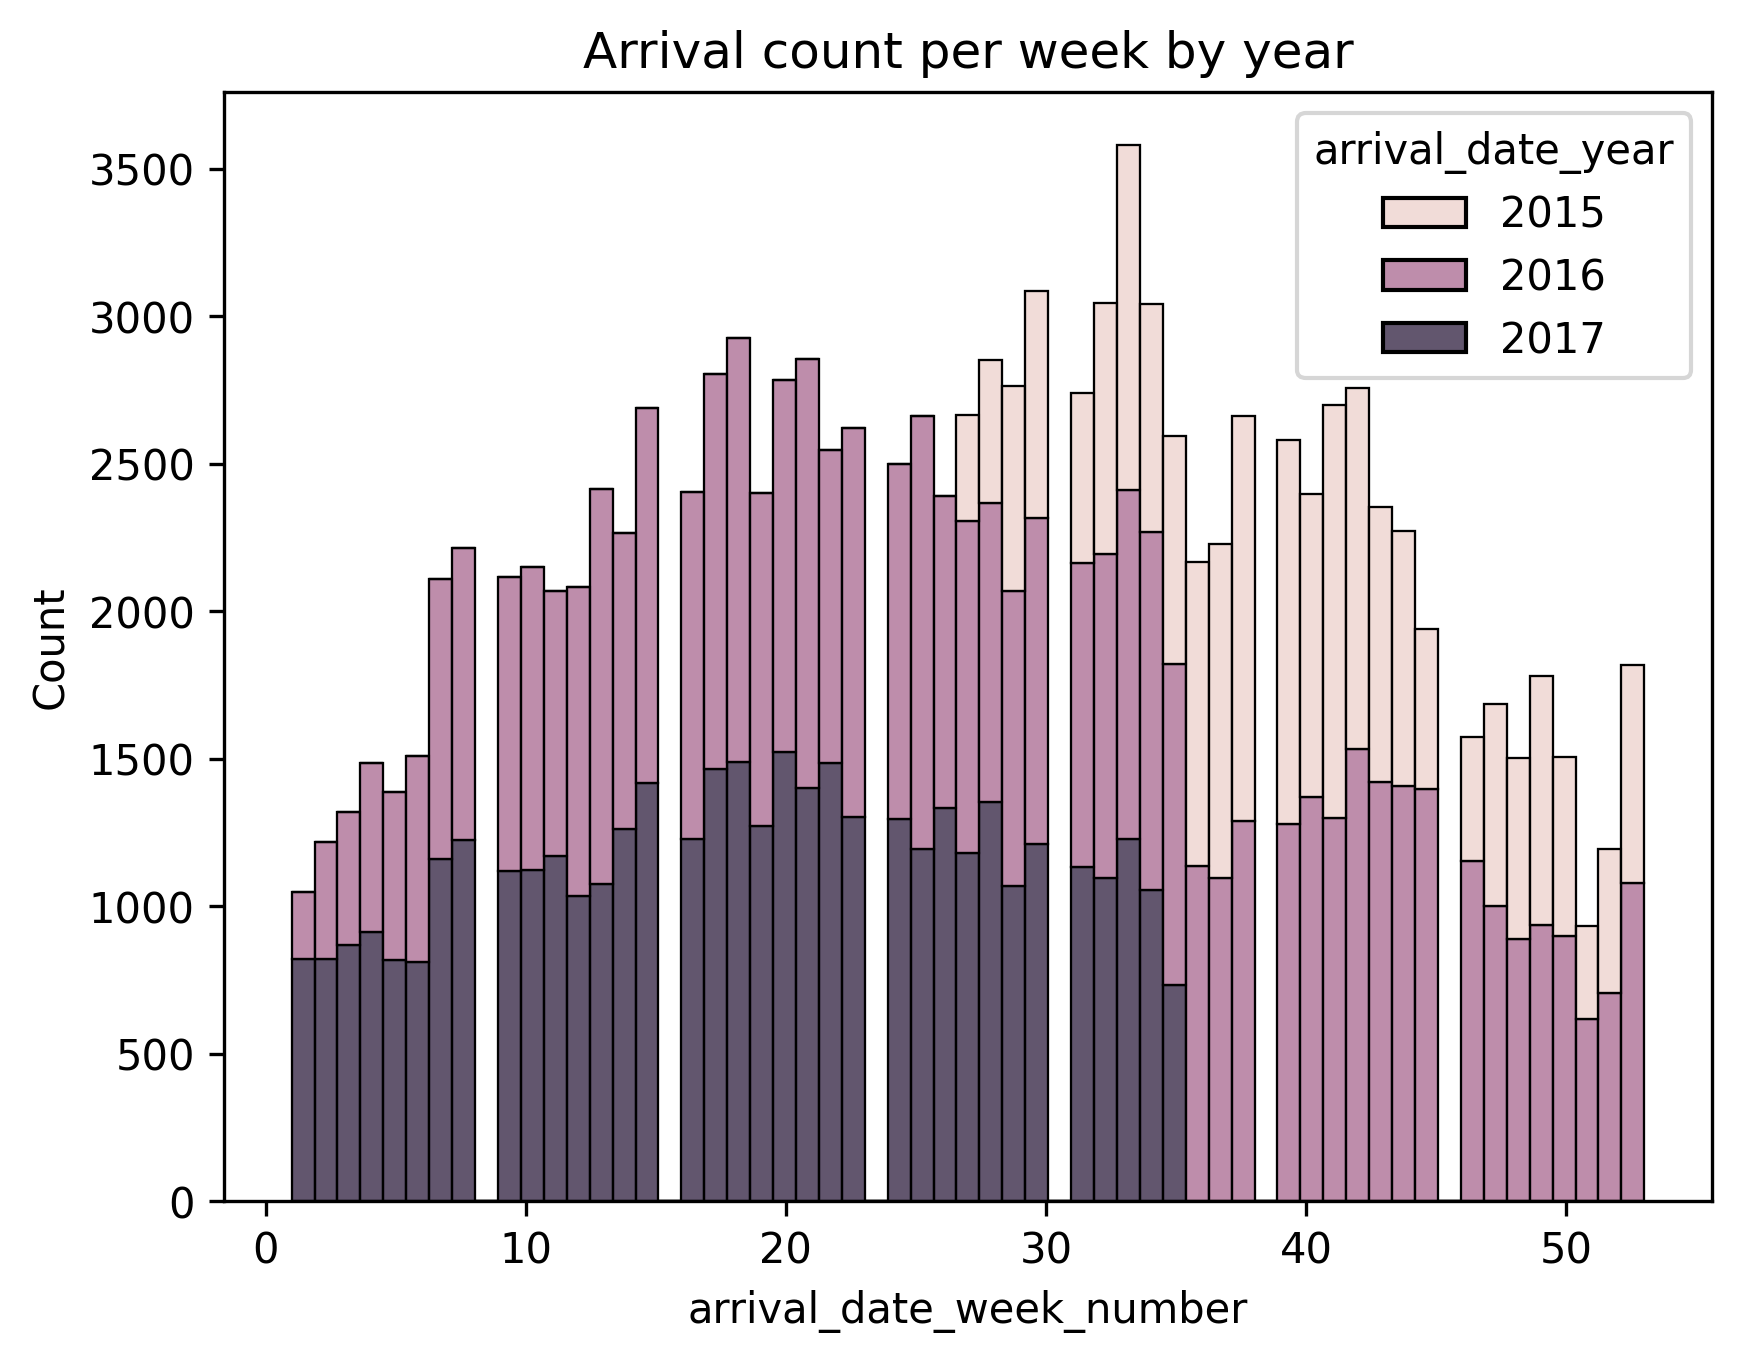

In [83]:
sns.histplot(df, x="arrival_date_week_number", hue='arrival_date_year', multiple="stack")
plt.title('Arrival count per week by year')
plt.show()

Important takeaways:

- We only have 1 full year of data (2016), other two are only partial 
- For some of the weeks numbers there is no data - that's weird! Since we have 2 different hotels in our dataset, something must have happened to our dataset or there are some other unexpected factors (e.g. collective vacations).

Let's now check for how common are reservation cancellations.

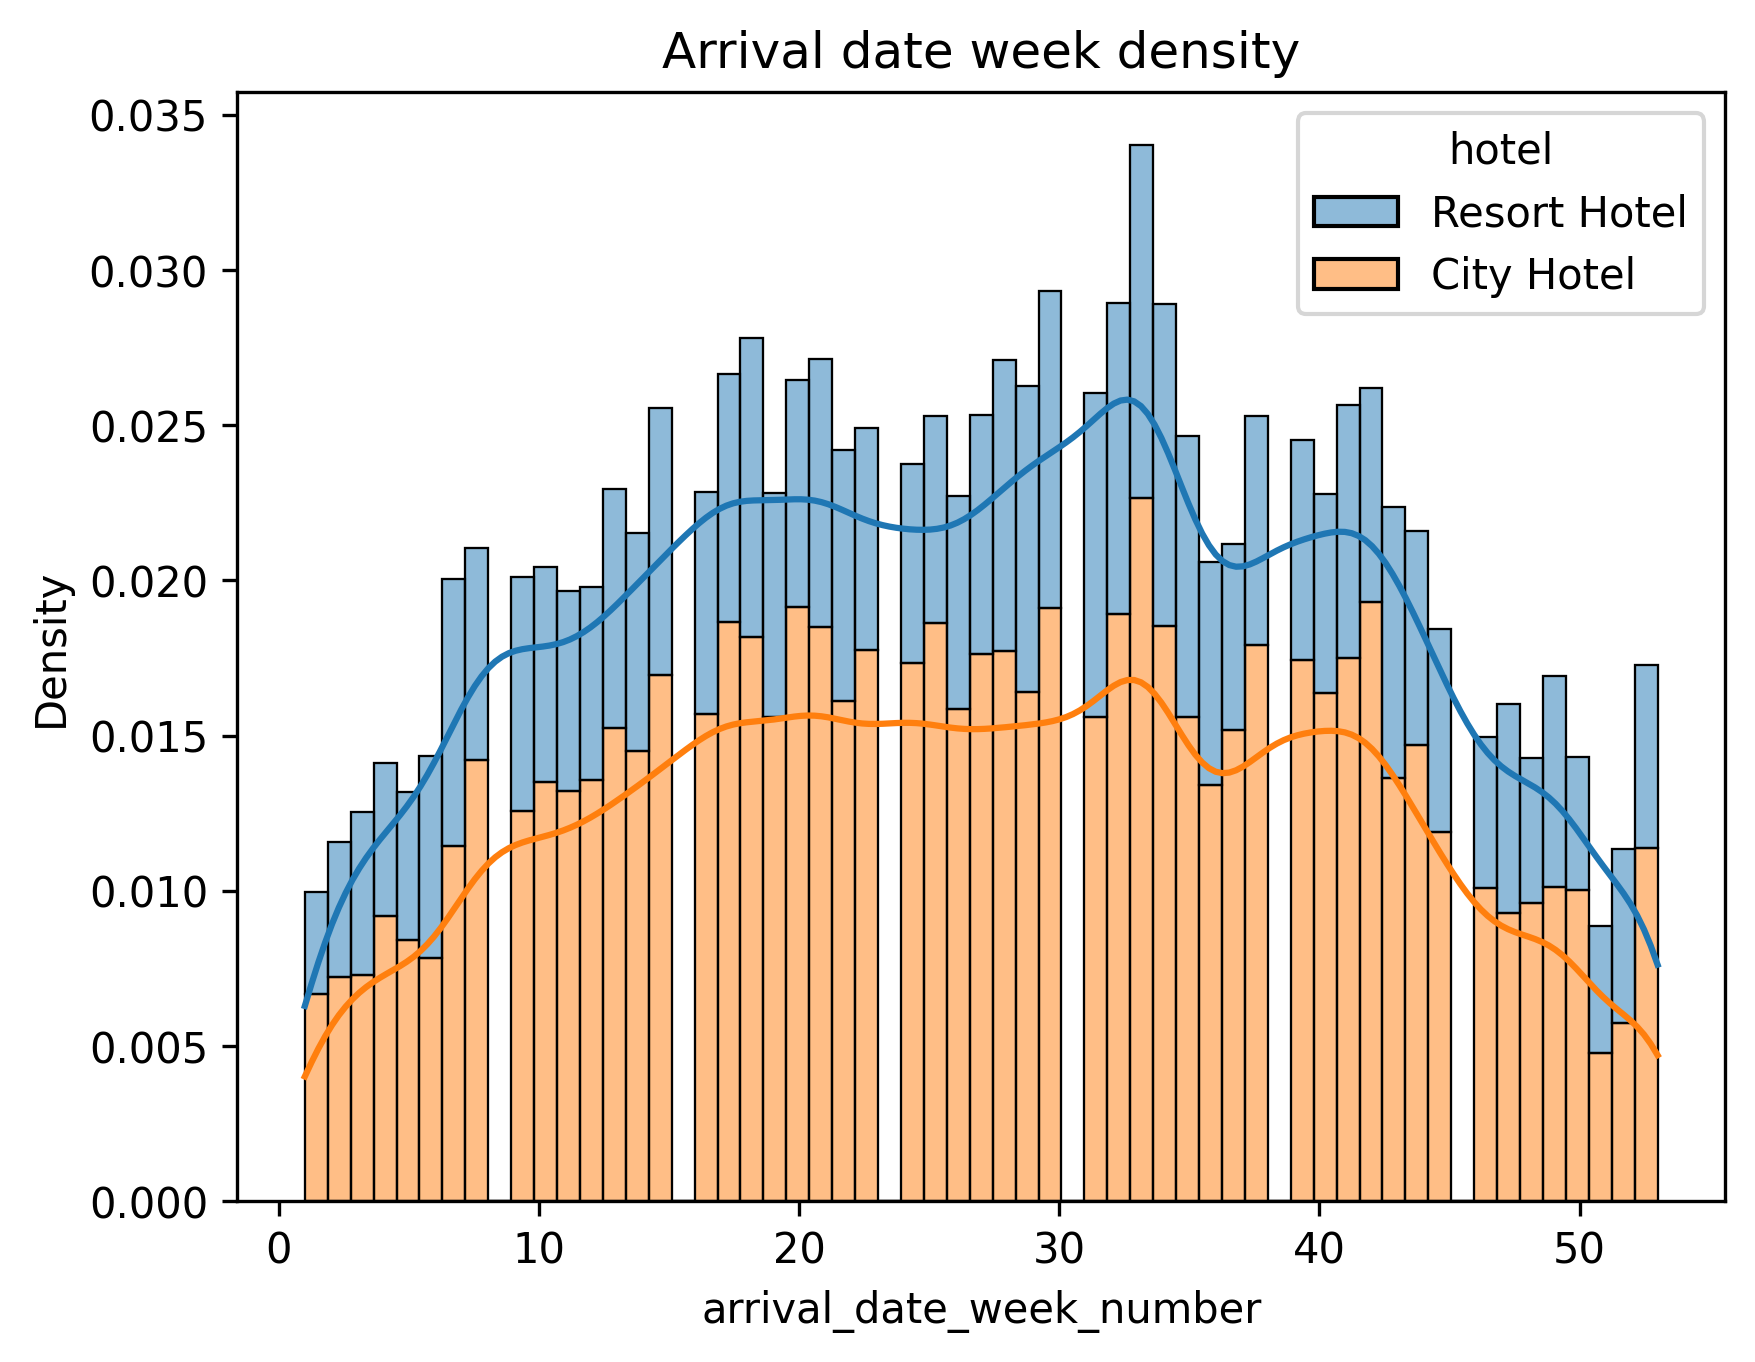

In [ ]:
sns.histplot(df, x="arrival_date_week_number", kde=True, label=True, stat='density', hue='hotel', multiple="stack")
plt.title('Arrival date week density with KDE')
plt.show()

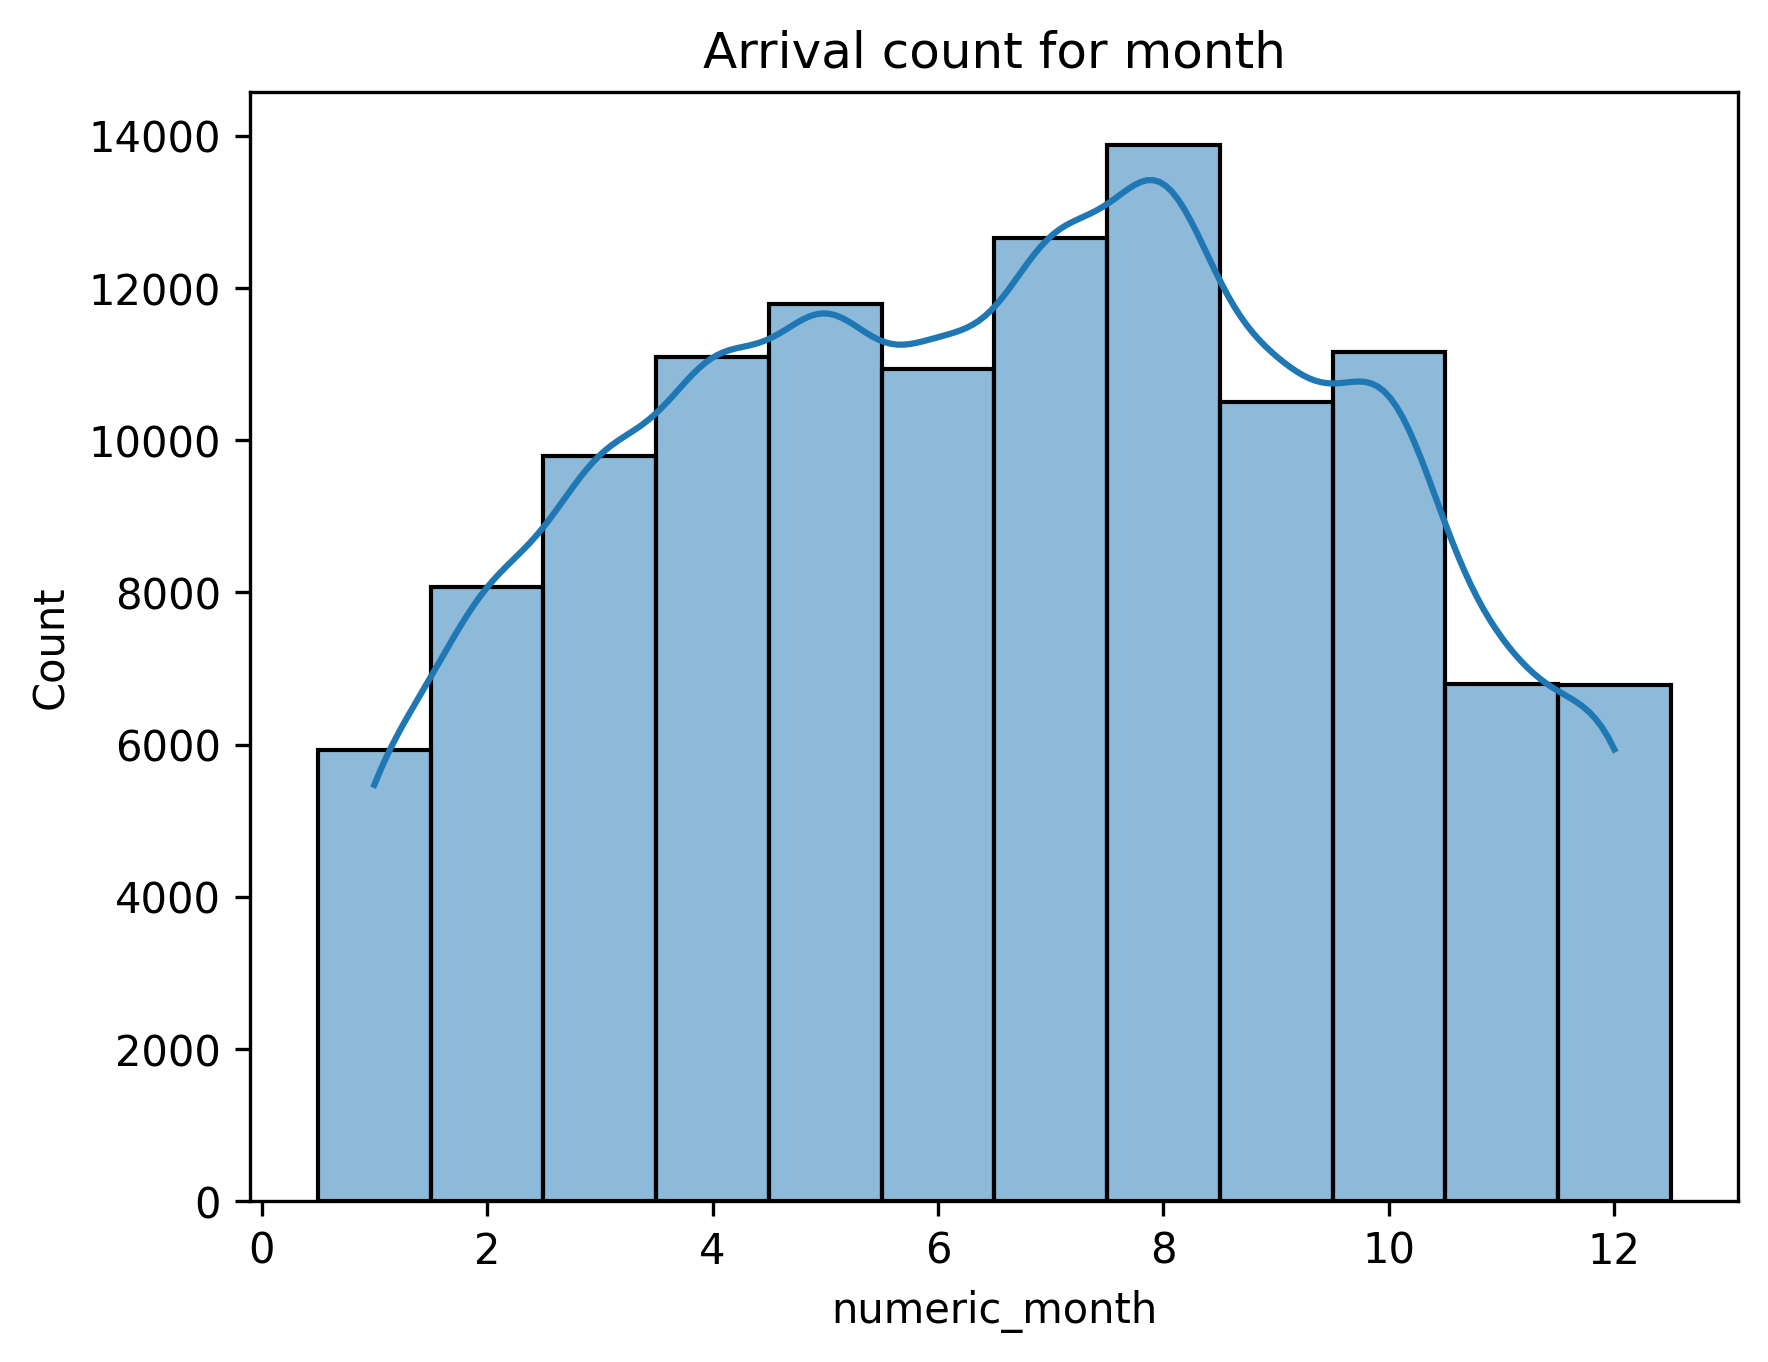

In [ ]:
df['numeric_month'] = pd.to_datetime(df['arrival_date_month'], format='%B').dt.month
sns.histplot(df, x="numeric_month", binwidth=1, discrete=True, kde=True, kde_kws={'bw_adjust': 1.8})
plt.title('Arrival count for month with KDE')
plt.show()

## Length of stay - distribution

- Draw up a distribution based on nights, do a KDE (lectures, vary Gaussian params)

In [84]:
df['total_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

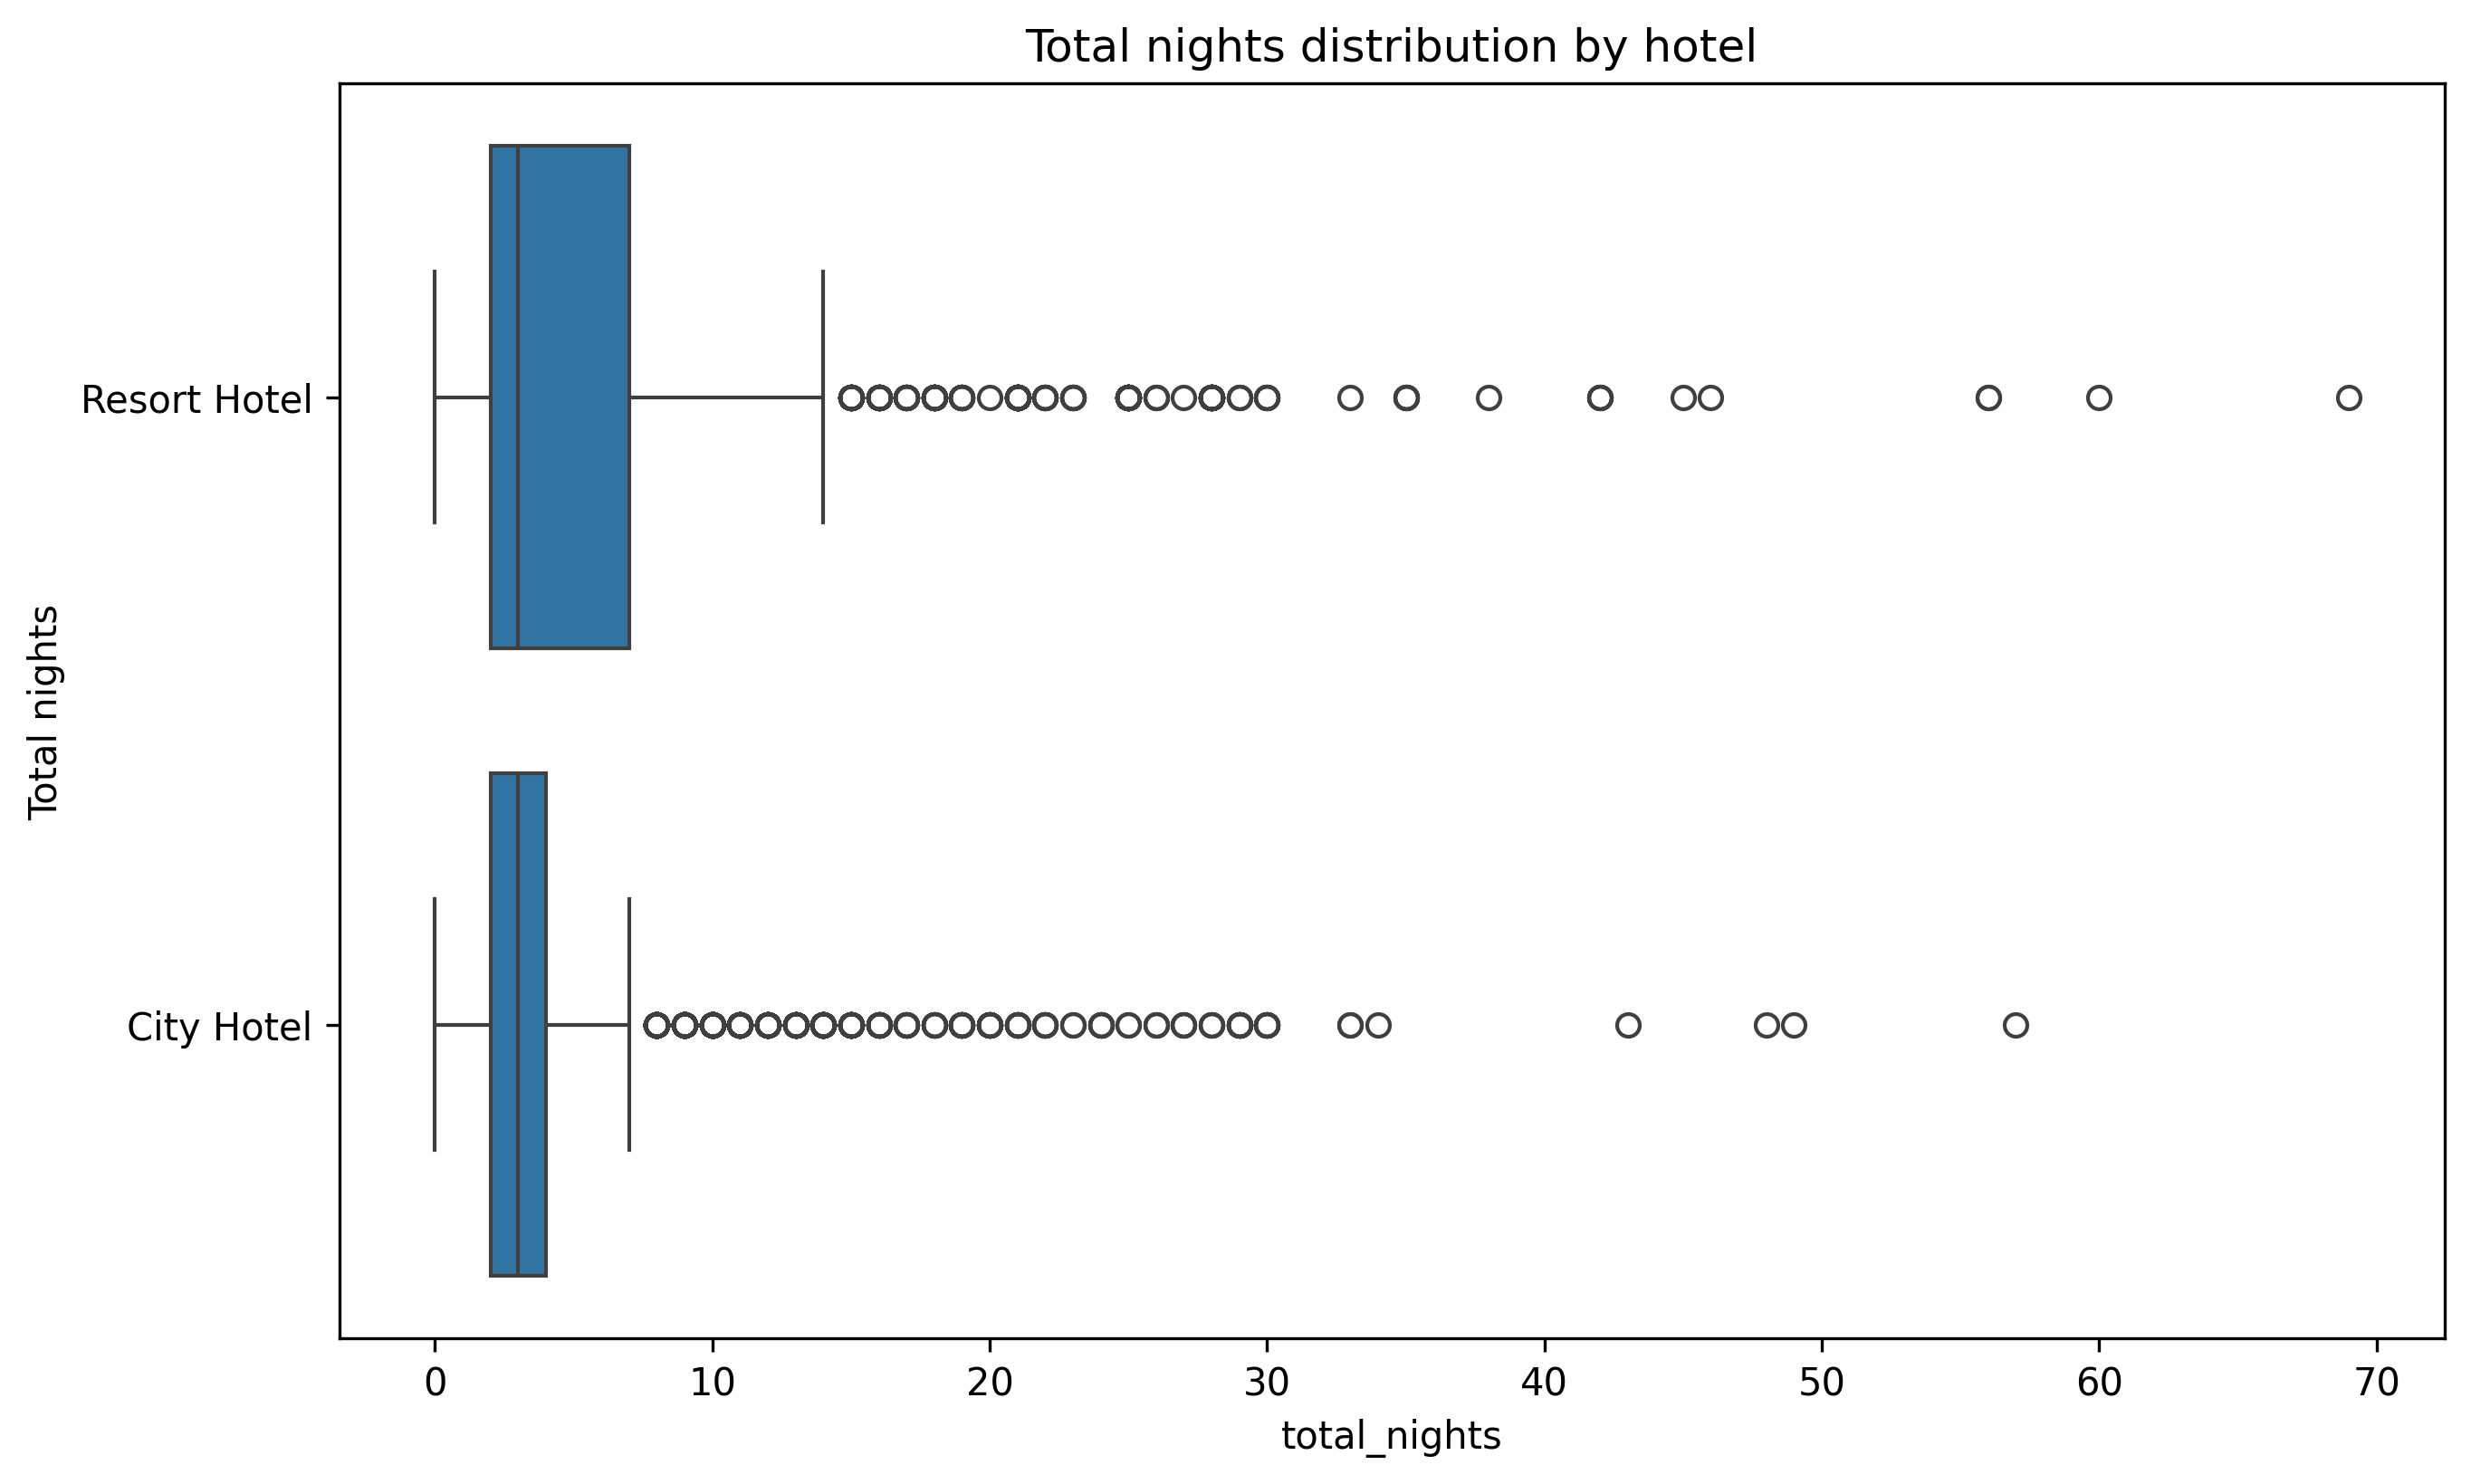

In [90]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='total_nights', y='hotel')
plt.ylabel('Total nights')
plt.title('Total nights distribution by hotel')
plt.show()

Key takeaways:
- There are *many* outliers in both cases!
- Plotting distributions will not be easy

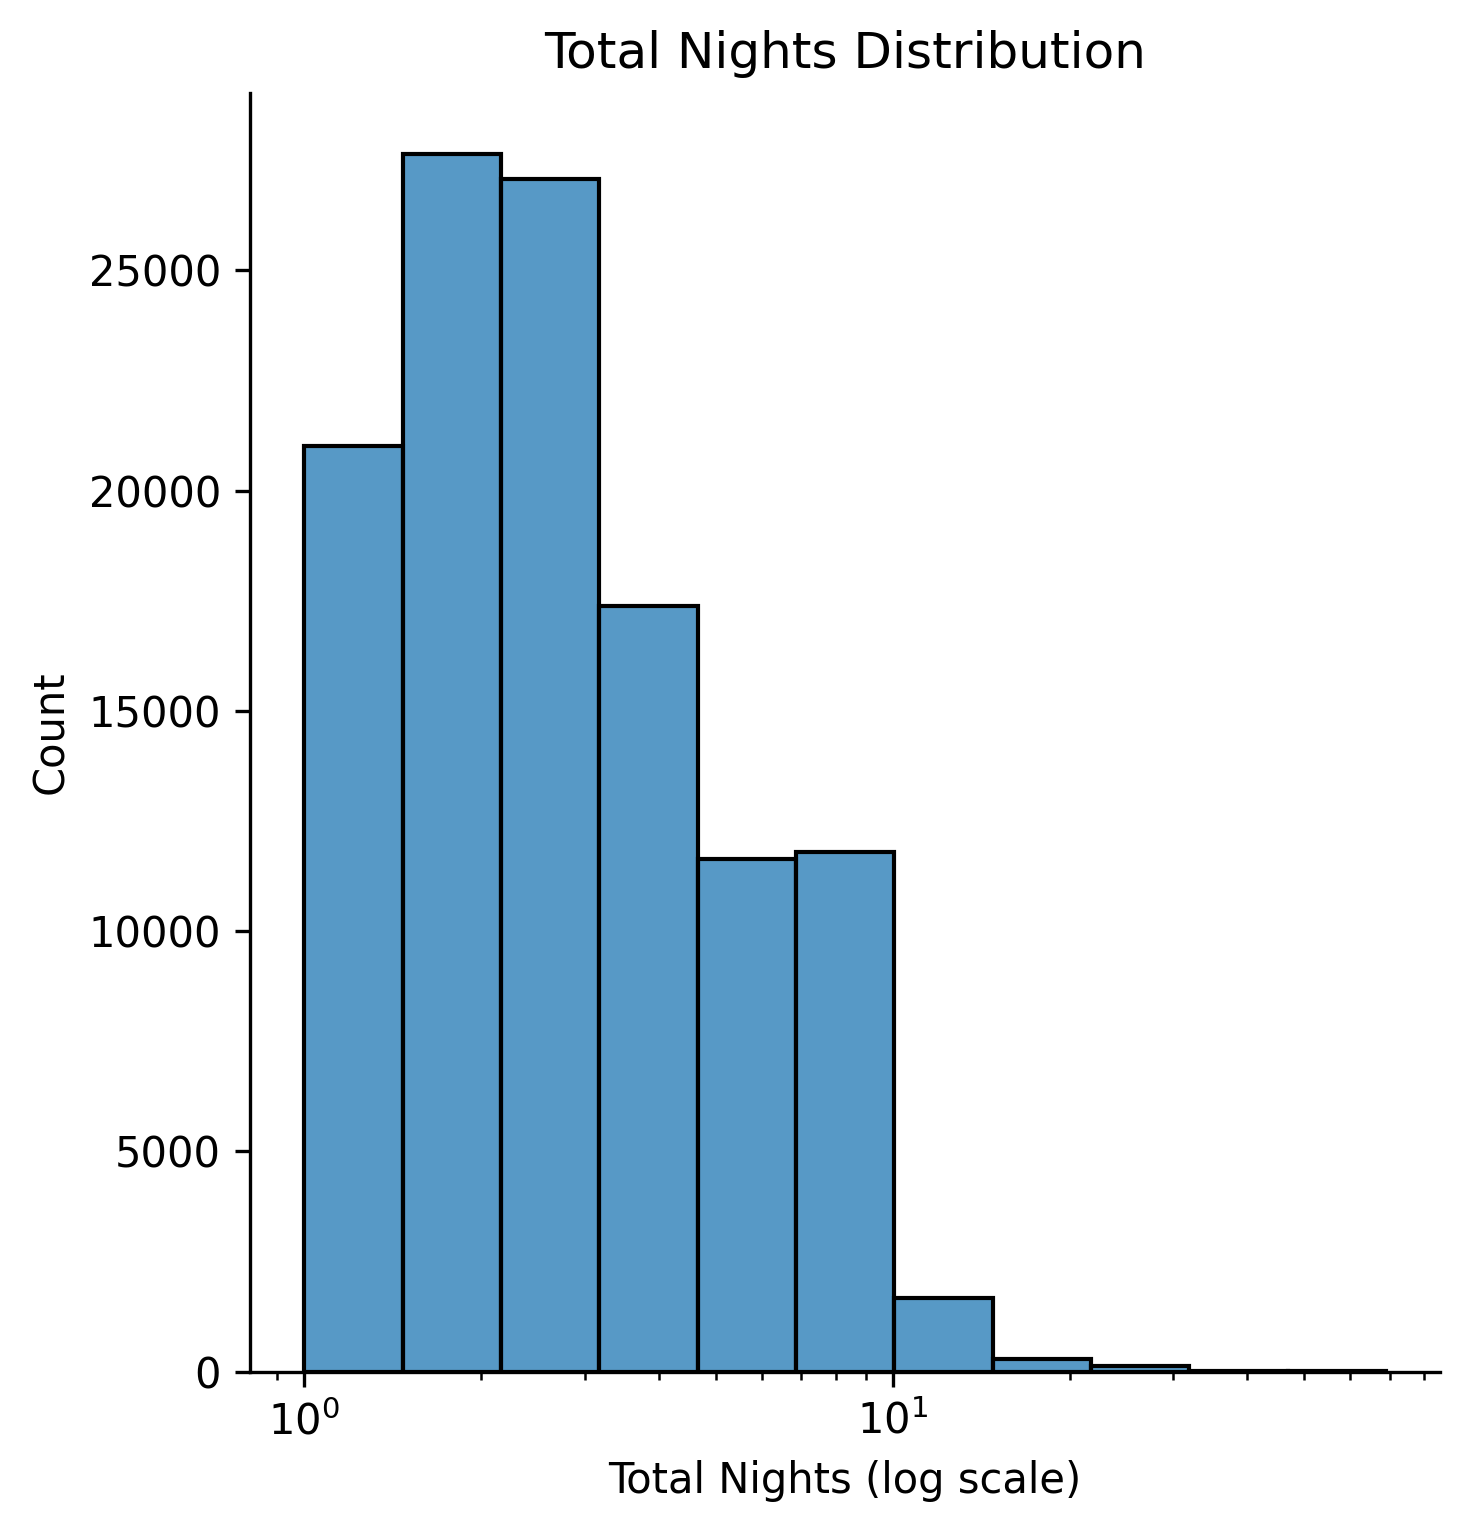

In [ ]:

sns.displot(df['total_nights'], bins=11, log_scale=True)
plt.title('Total Nights Histogram')
plt.xlabel('Total Nights (log scale)')
plt.ylabel('Count')
plt.show()

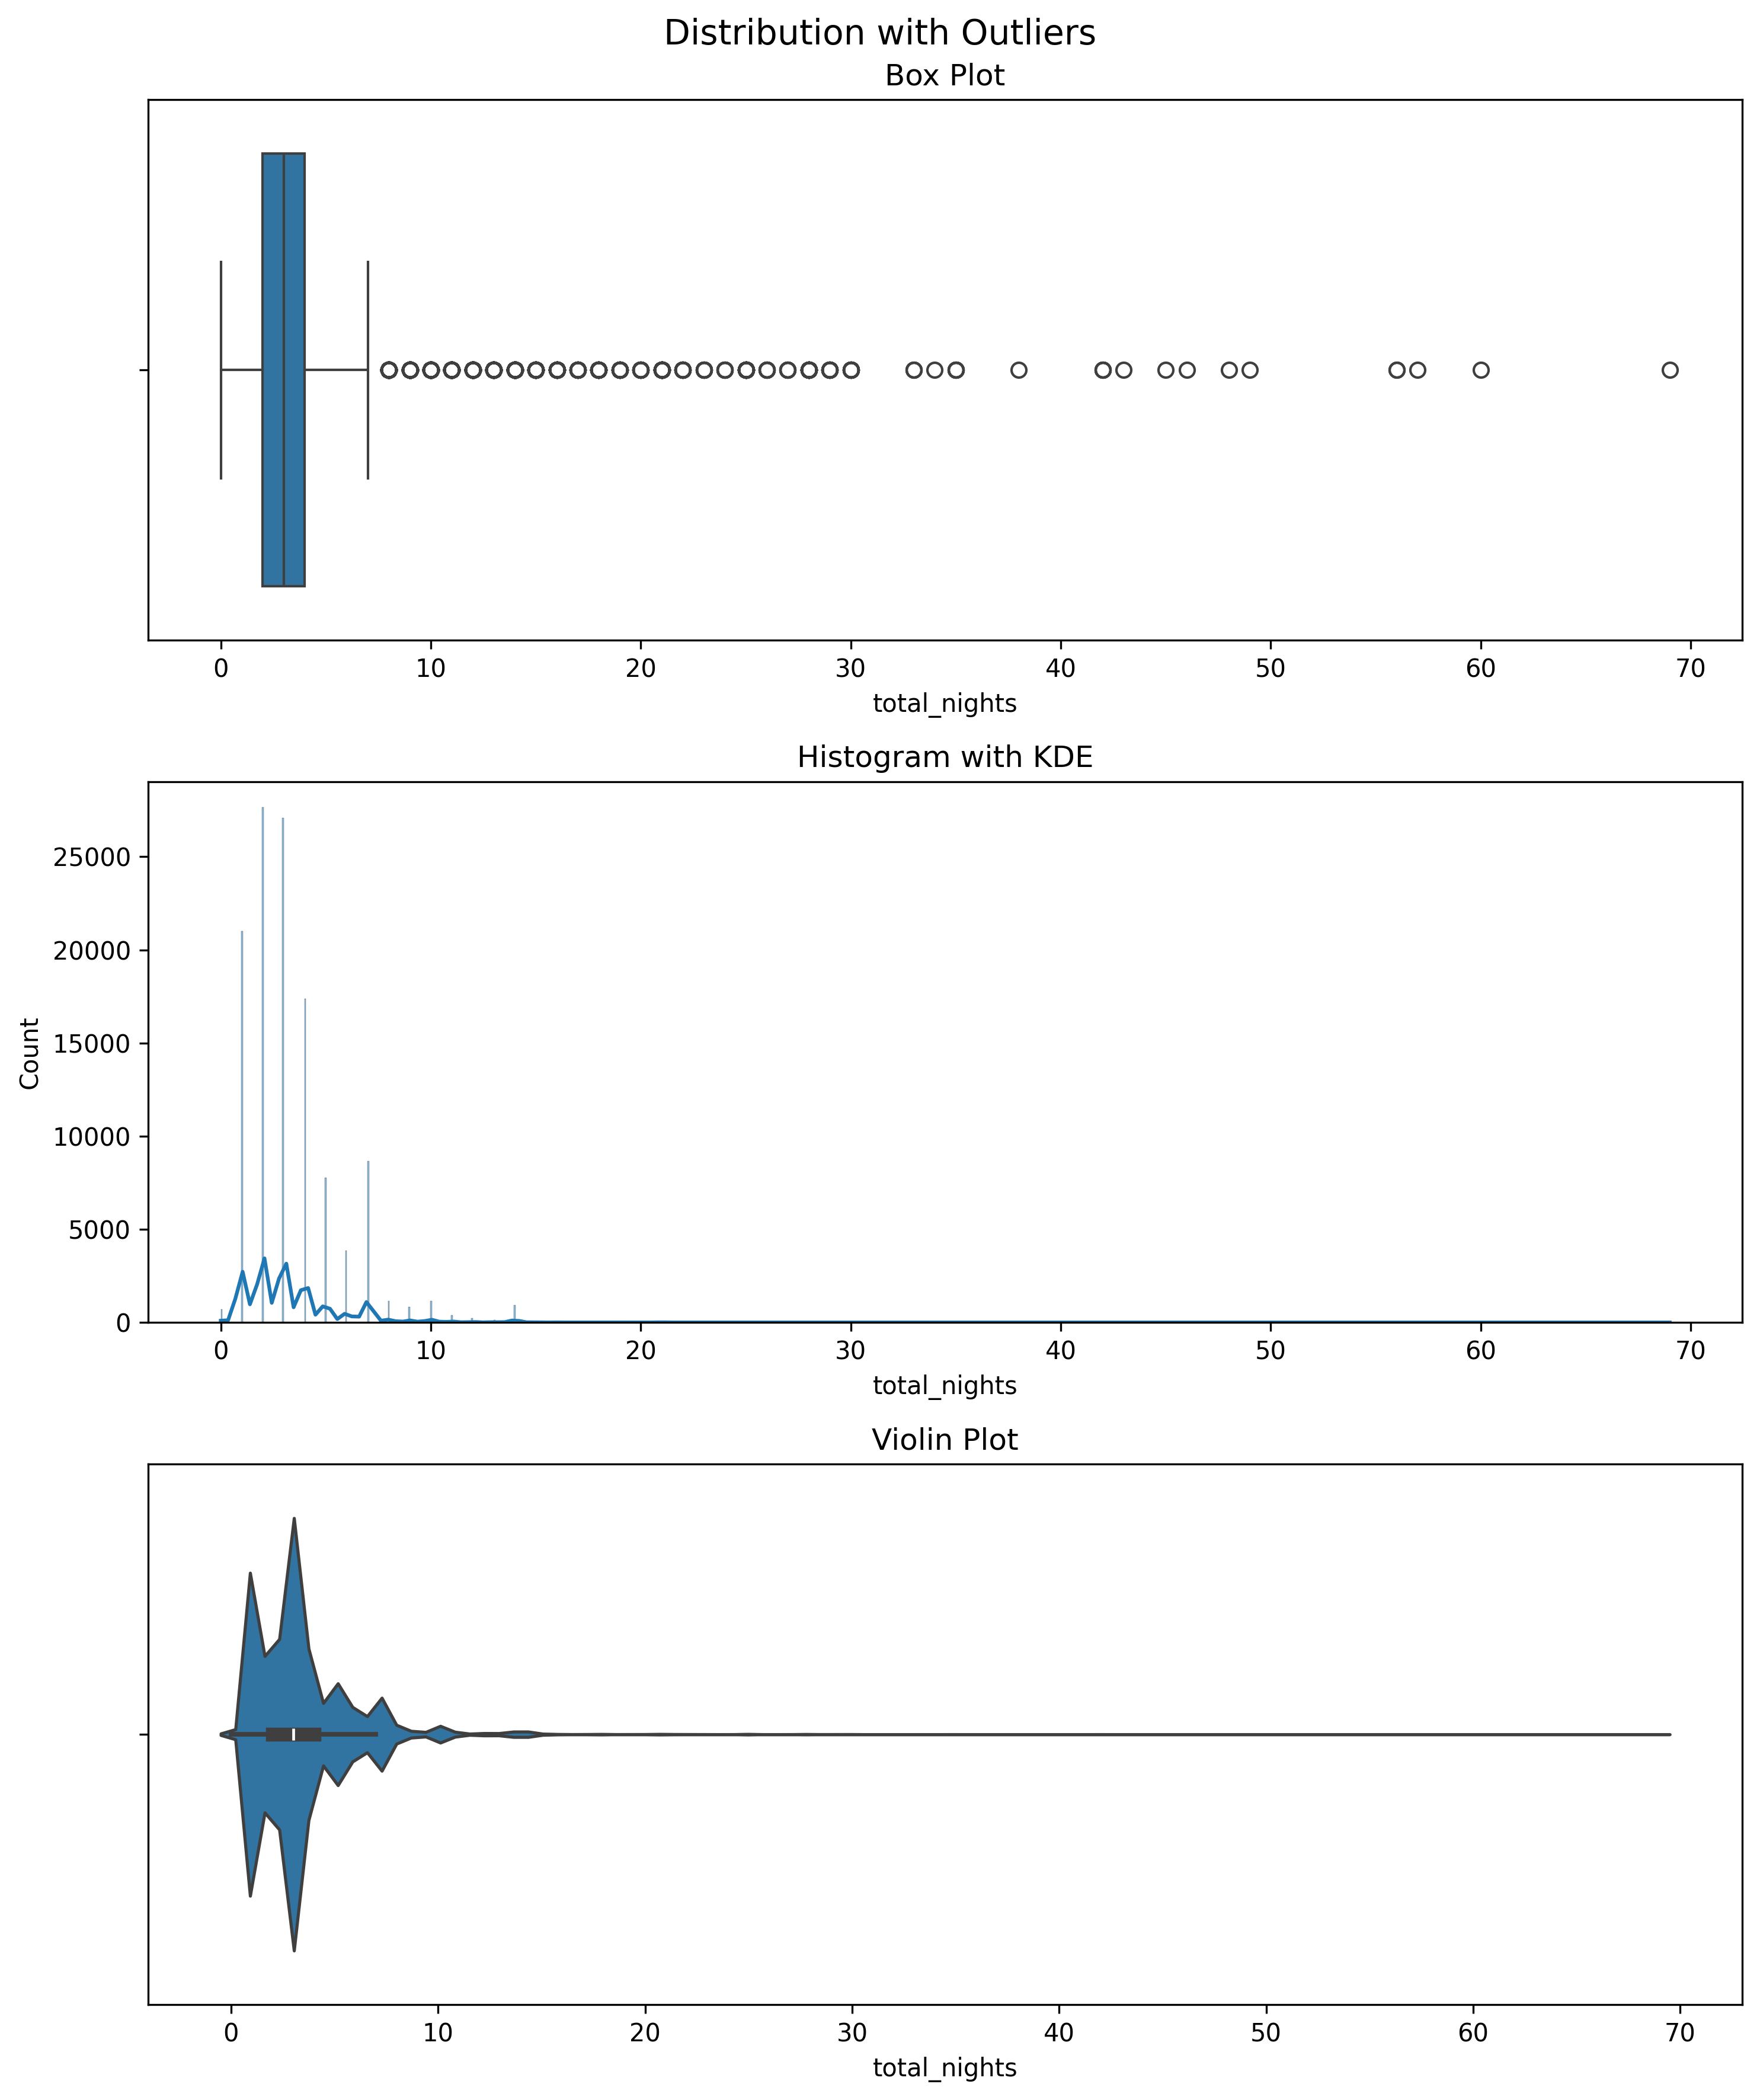

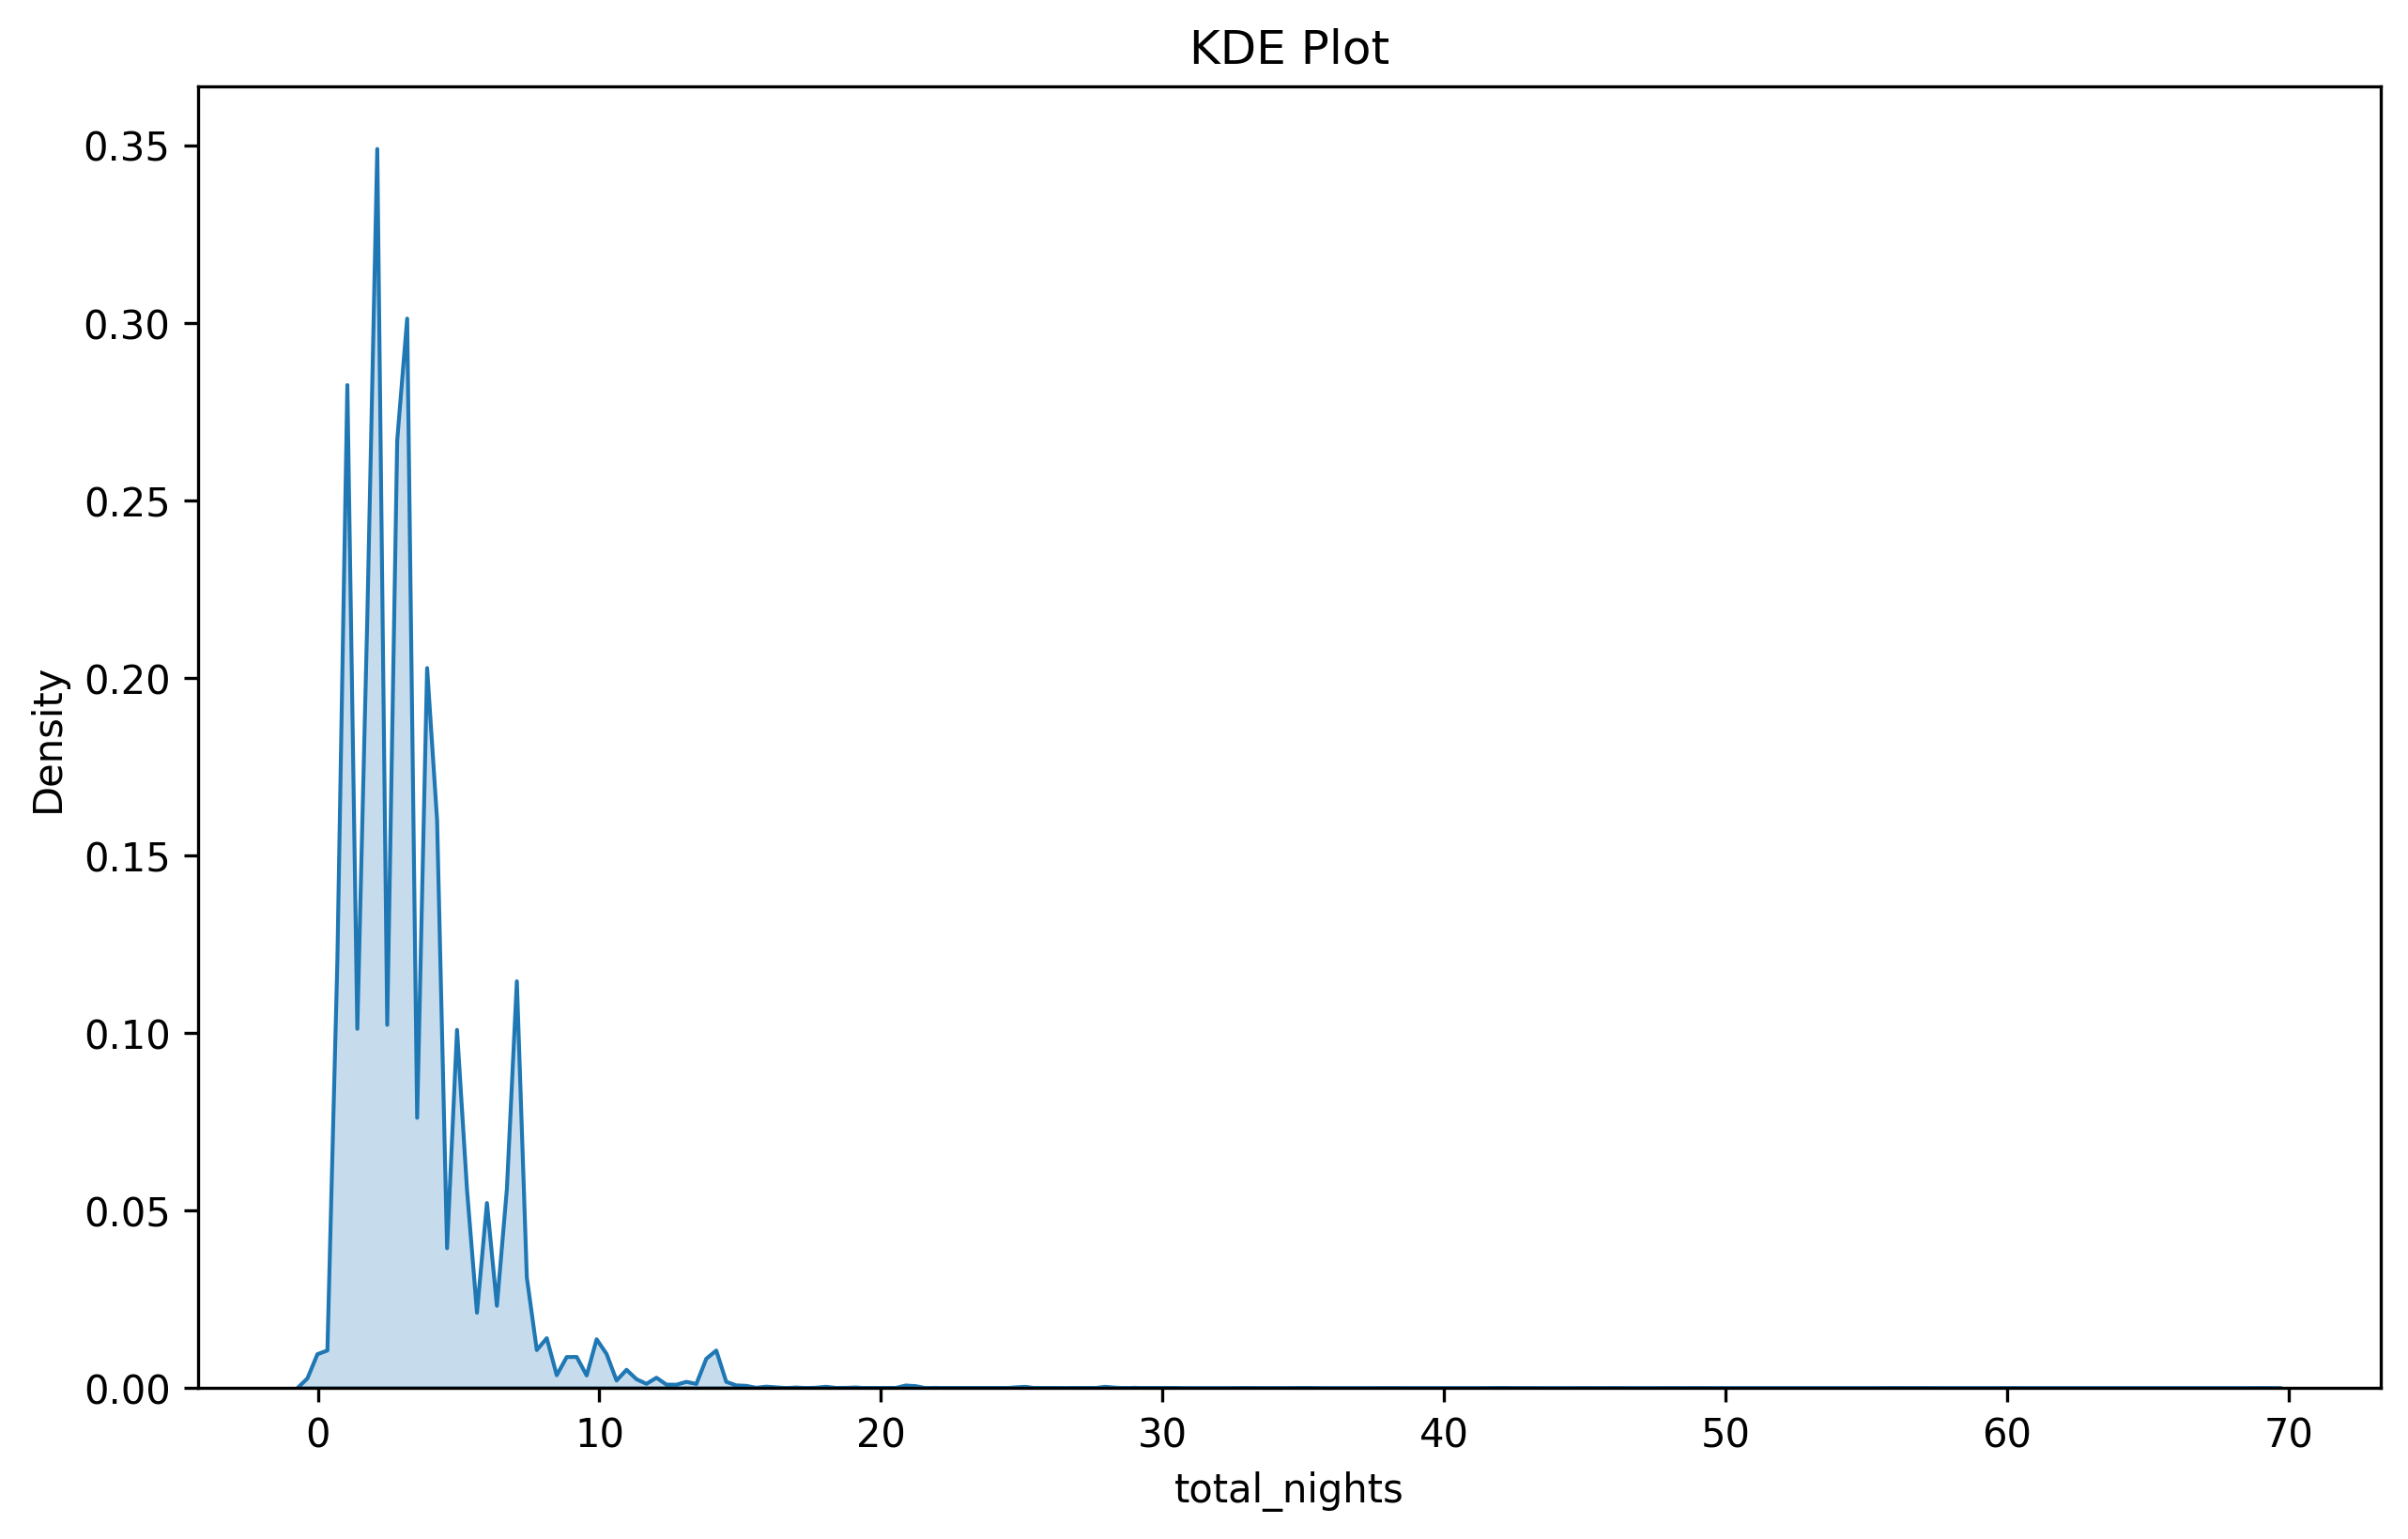

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example code with multiple visualization options
def plot_distribution_with_outliers(data, title="Distribution Plot"):
    # Create a figure with multiple subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle(title, fontsize=14)
    
    # 1. Box plot
    sns.boxplot(x=data, ax=ax1)
    ax1.set_title("Box Plot")
    
    # 2. Histogram with KDE
    sns.histplot(data=data, kde=True, ax=ax2)
    ax2.set_title("Histogram with KDE")
    
    # 3. Violin plot
    sns.violinplot(x=data, ax=ax3)
    ax3.set_title("Violin Plot")
    
    plt.tight_layout()
    plt.show()

    # Optional: Create separate plot for better KDE visualization
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=data, fill=True)
    plt.title("KDE Plot")
    plt.show()

# Plot the distribution
plot_distribution_with_outliers(df['total_nights'], "Distribution with Outliers")

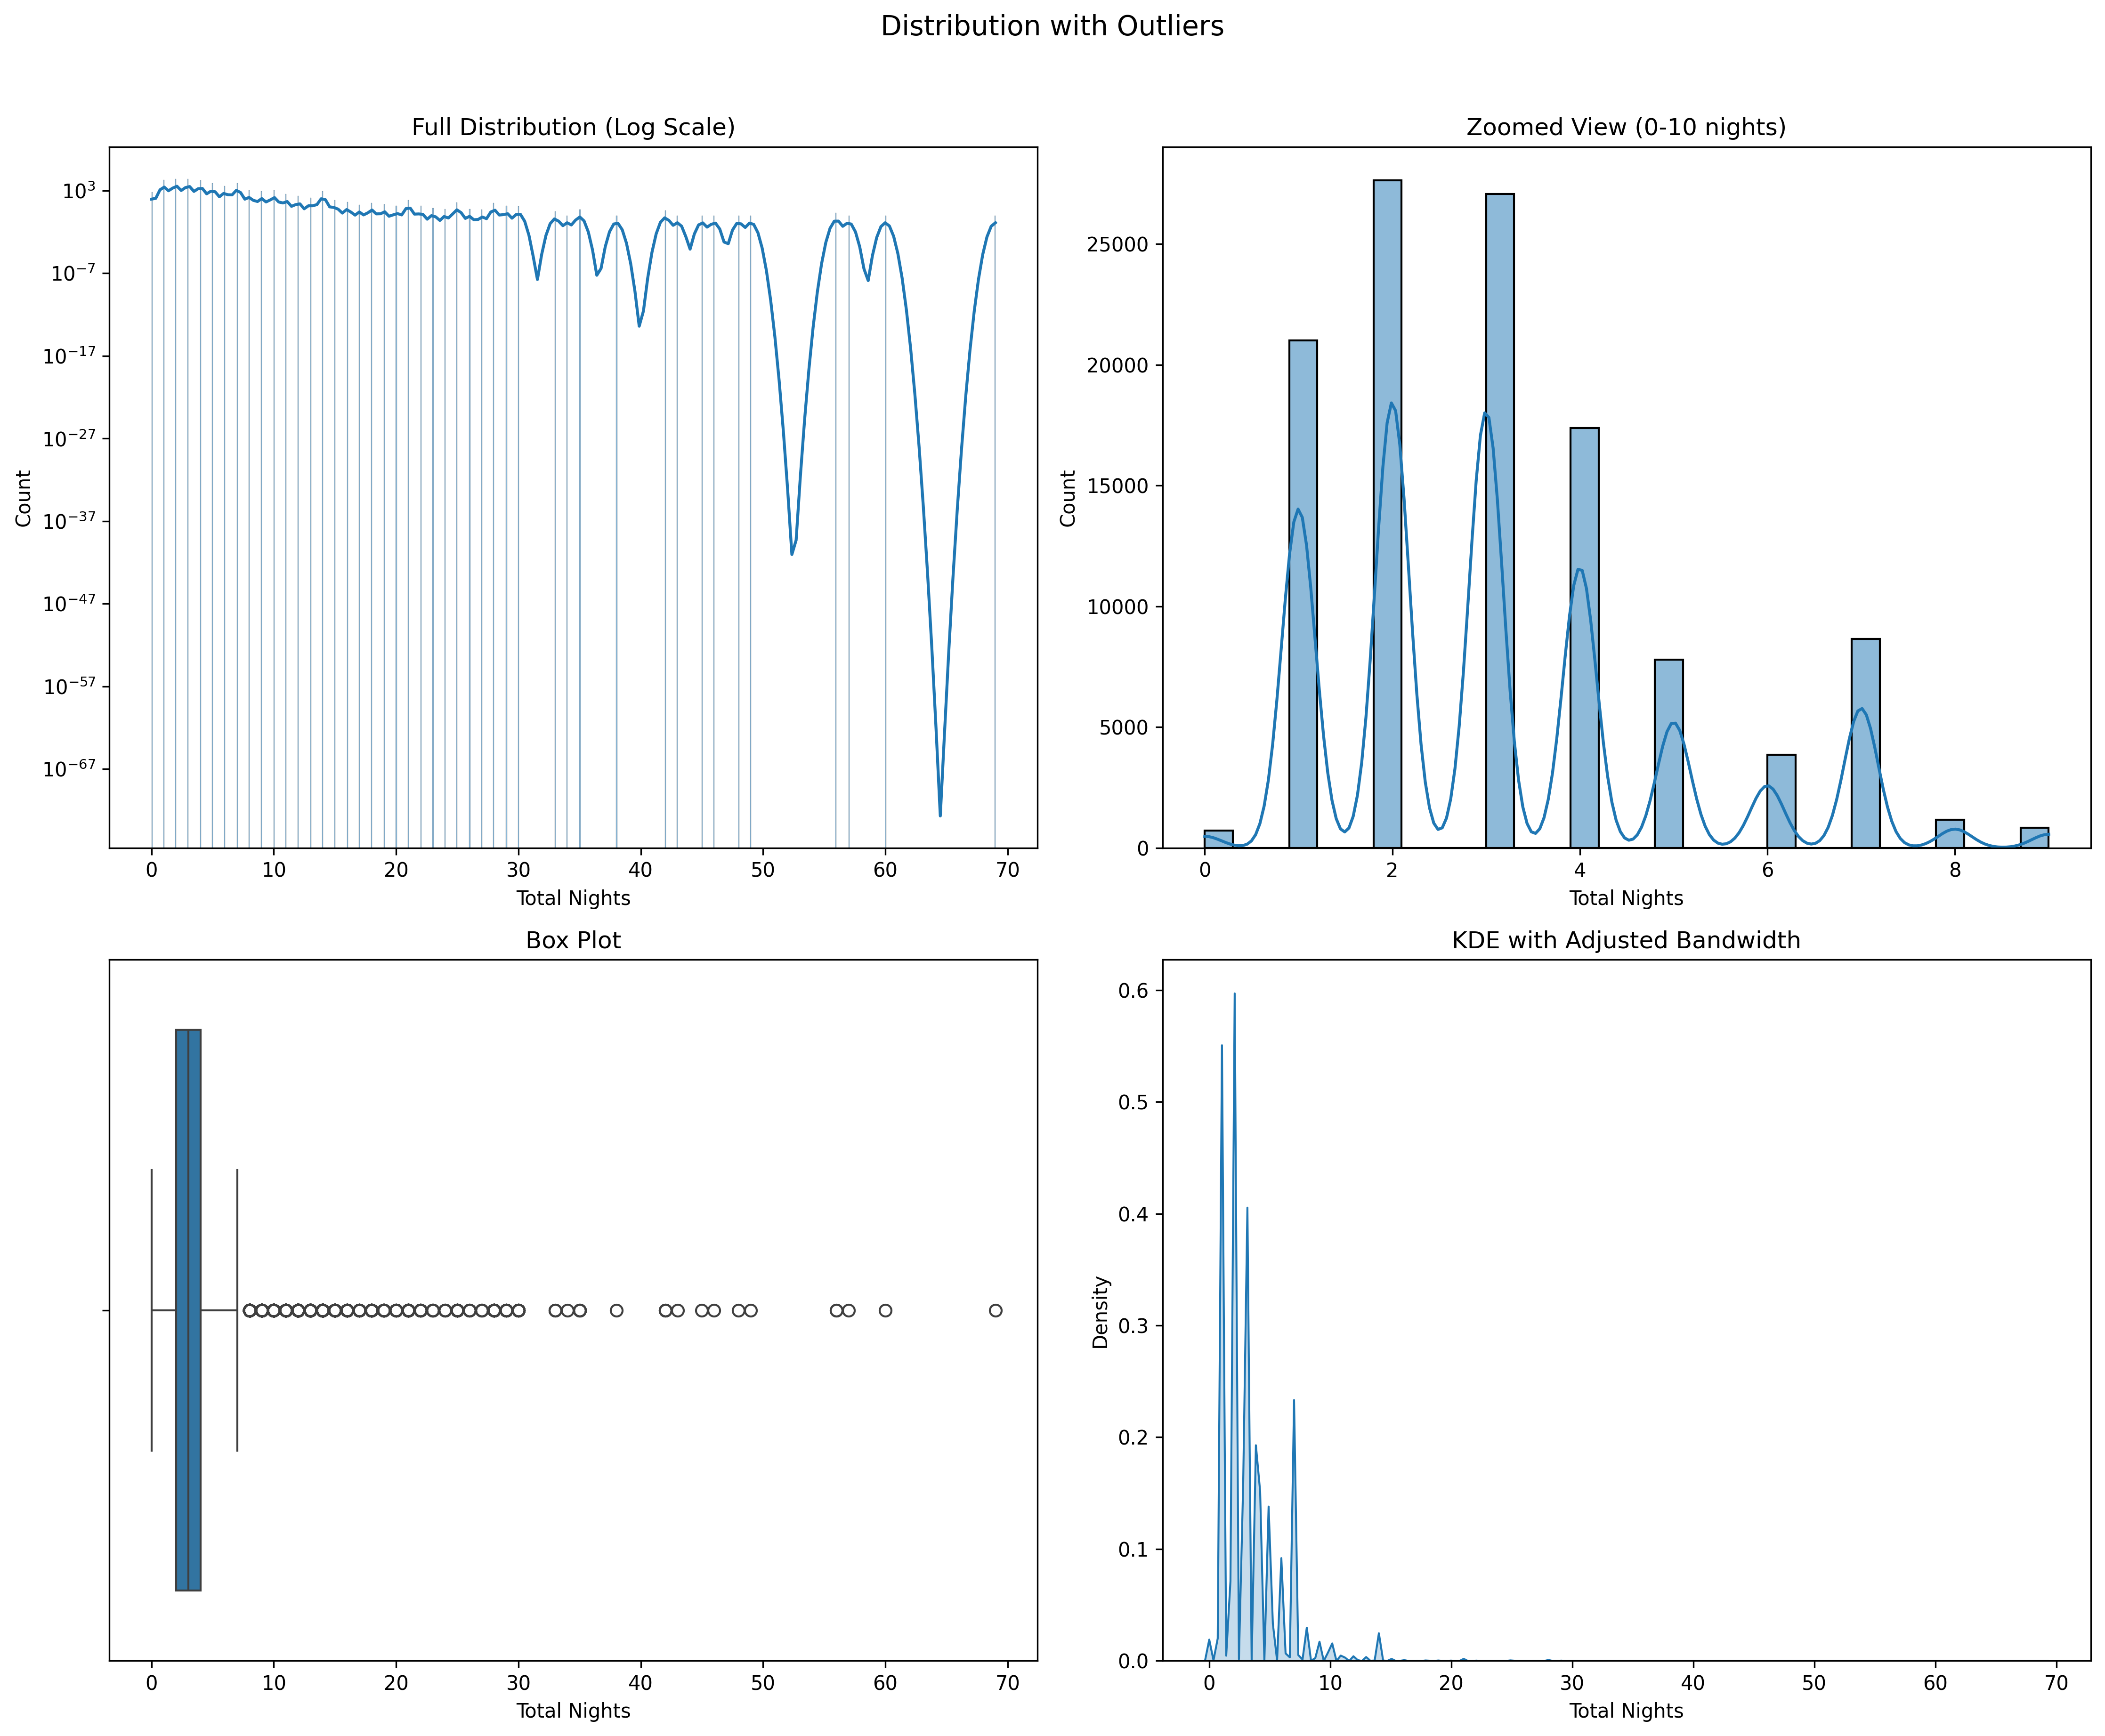

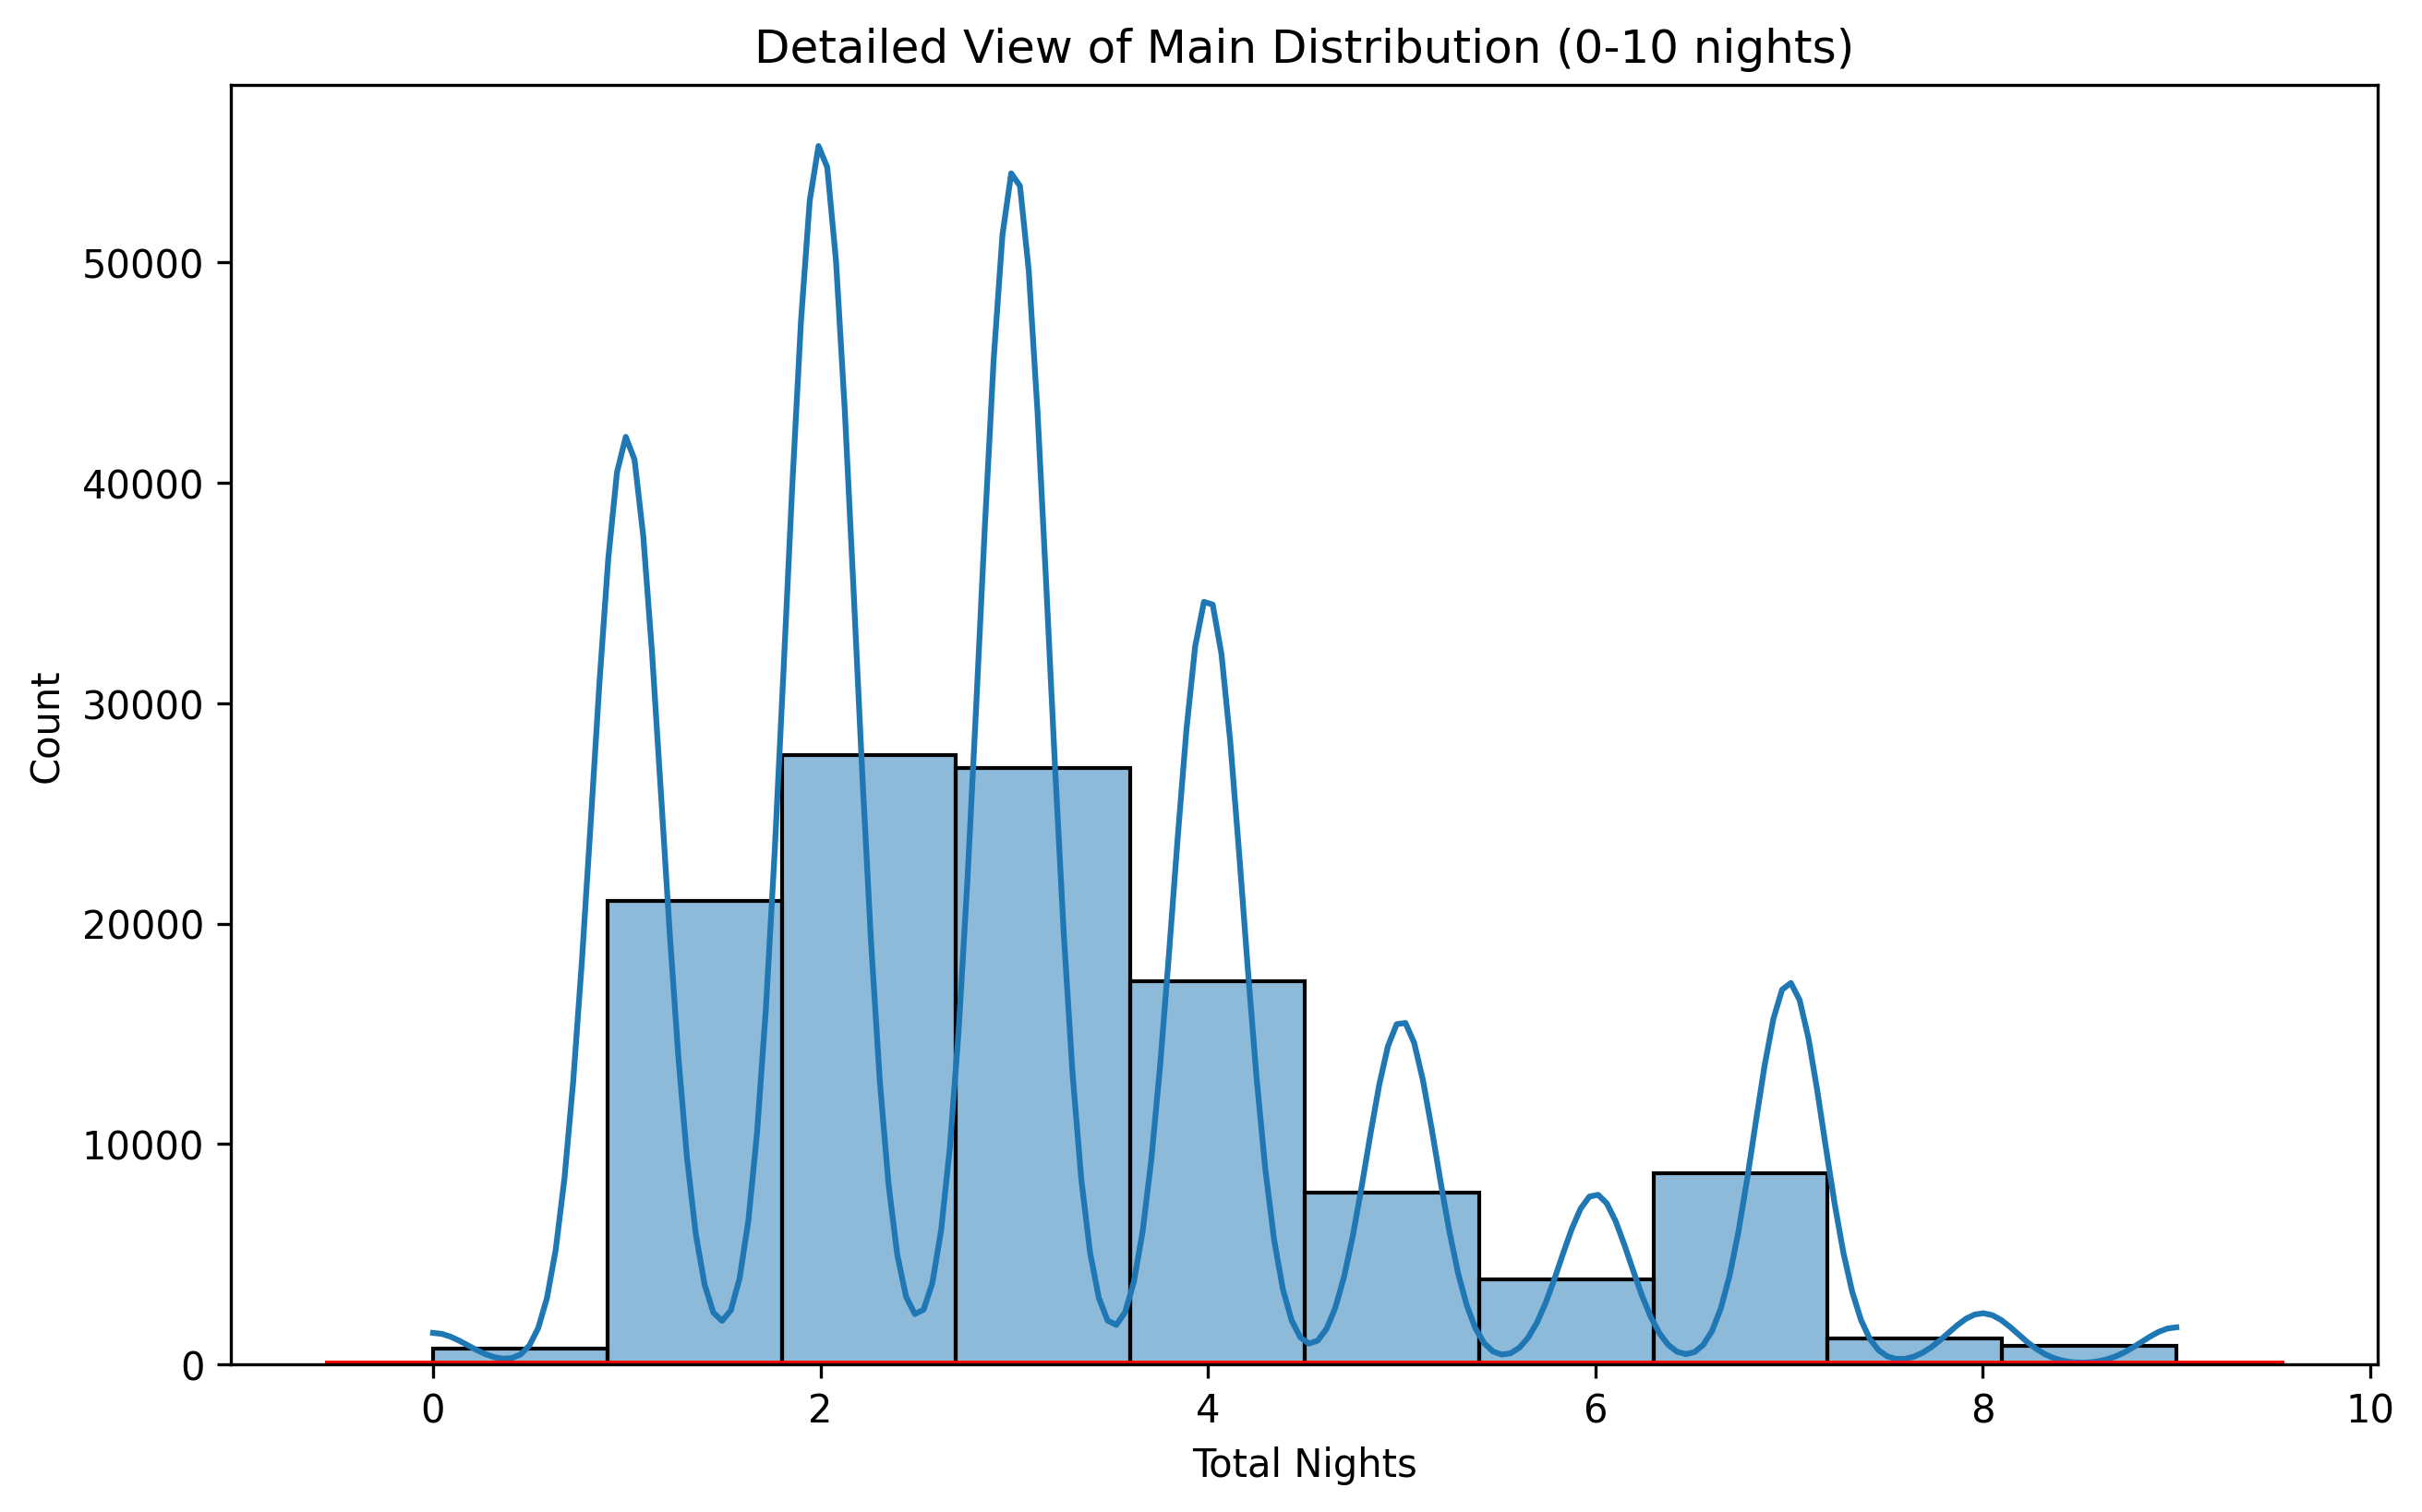

In [78]:
def plot_distribution_with_outliers(data, title="Distribution Plot"):
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 12))
    
    # 1. Full range with log scale
    ax1 = plt.subplot(221)
    sns.histplot(data=data, kde=True, ax=ax1)
    ax1.set_yscale('log')
    ax1.set_title("Full Distribution (Log Scale)")
    ax1.set_xlabel("Total Nights")
    
    # 2. Zoomed view of main distribution (0-10 nights)
    ax2 = plt.subplot(222)
    sns.histplot(data=data[data < 10], kde=True, bins=30, ax=ax2)
    ax2.set_title("Zoomed View (0-10 nights)")
    ax2.set_xlabel("Total Nights")
    
    # 3. Box plot
    ax3 = plt.subplot(223)
    sns.boxplot(x=data, ax=ax3)
    ax3.set_title("Box Plot")
    ax3.set_xlabel("Total Nights")
    
    # 4. KDE with adjusted bandwidth
    ax4 = plt.subplot(224)
    sns.kdeplot(data=data, bw_adjust=0.5, fill=True, ax=ax4)
    ax4.set_title("KDE with Adjusted Bandwidth")
    ax4.set_xlabel("Total Nights")
    
    # Add overall title
    fig.suptitle(title, fontsize=14, y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    # Optional: Detailed view of main distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data[data < 10], kde=True, bins=10)
    sns.kdeplot(data=data[data < 10], color='red', linewidth=2)
    plt.title("Detailed View of Main Distribution (0-10 nights)")
    plt.xlabel("Total Nights")
    plt.ylabel("Count")
    plt.show()

plot_distribution_with_outliers(df['total_nights'], "Distribution with Outliers")

## Biggest group of guests

Find out what's the reservation with the biggest number of guests that was not canceled.

In [79]:
df['total_guests'] = df['adults'] + df['children'] + df['babies']
df_valid = df[df['is_canceled'] == 0]
df_valid = df_valid.groupby('total_guests').size().reset_index(name='count').sort_values('total_guests', ascending=False)
HTML(df_valid.to_html(index=False, classes='table-style').replace('<table', '<table style="text-align: left"'))

total_guests,count
12.0,1
10.0,1
5.0,103
4.0,2283
3.0,7118
2.0,49479
1.0,16026
0.0,155


The biggest not cancelled stay was with 12 guests as shown below.

In [80]:
mask = (df['total_guests'] == 12) & (df['is_canceled'] == 0)
HTML(df[mask].to_html(index=False, classes='table-style').replace('<table', '<table style="text-align: left"'))

hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,numeric_month,total_nights,total_guests
City Hotel,0,37,2016,January,3,12,0,2,2,0.0,10,0,0,0,D,D,1,2,12.0


## Cancellation rate as a function of lead time

We'll plot the cancellation rate of the bookings as a function of lead time. We suspect that bookings made further in advance are more likely to be cancelled. 

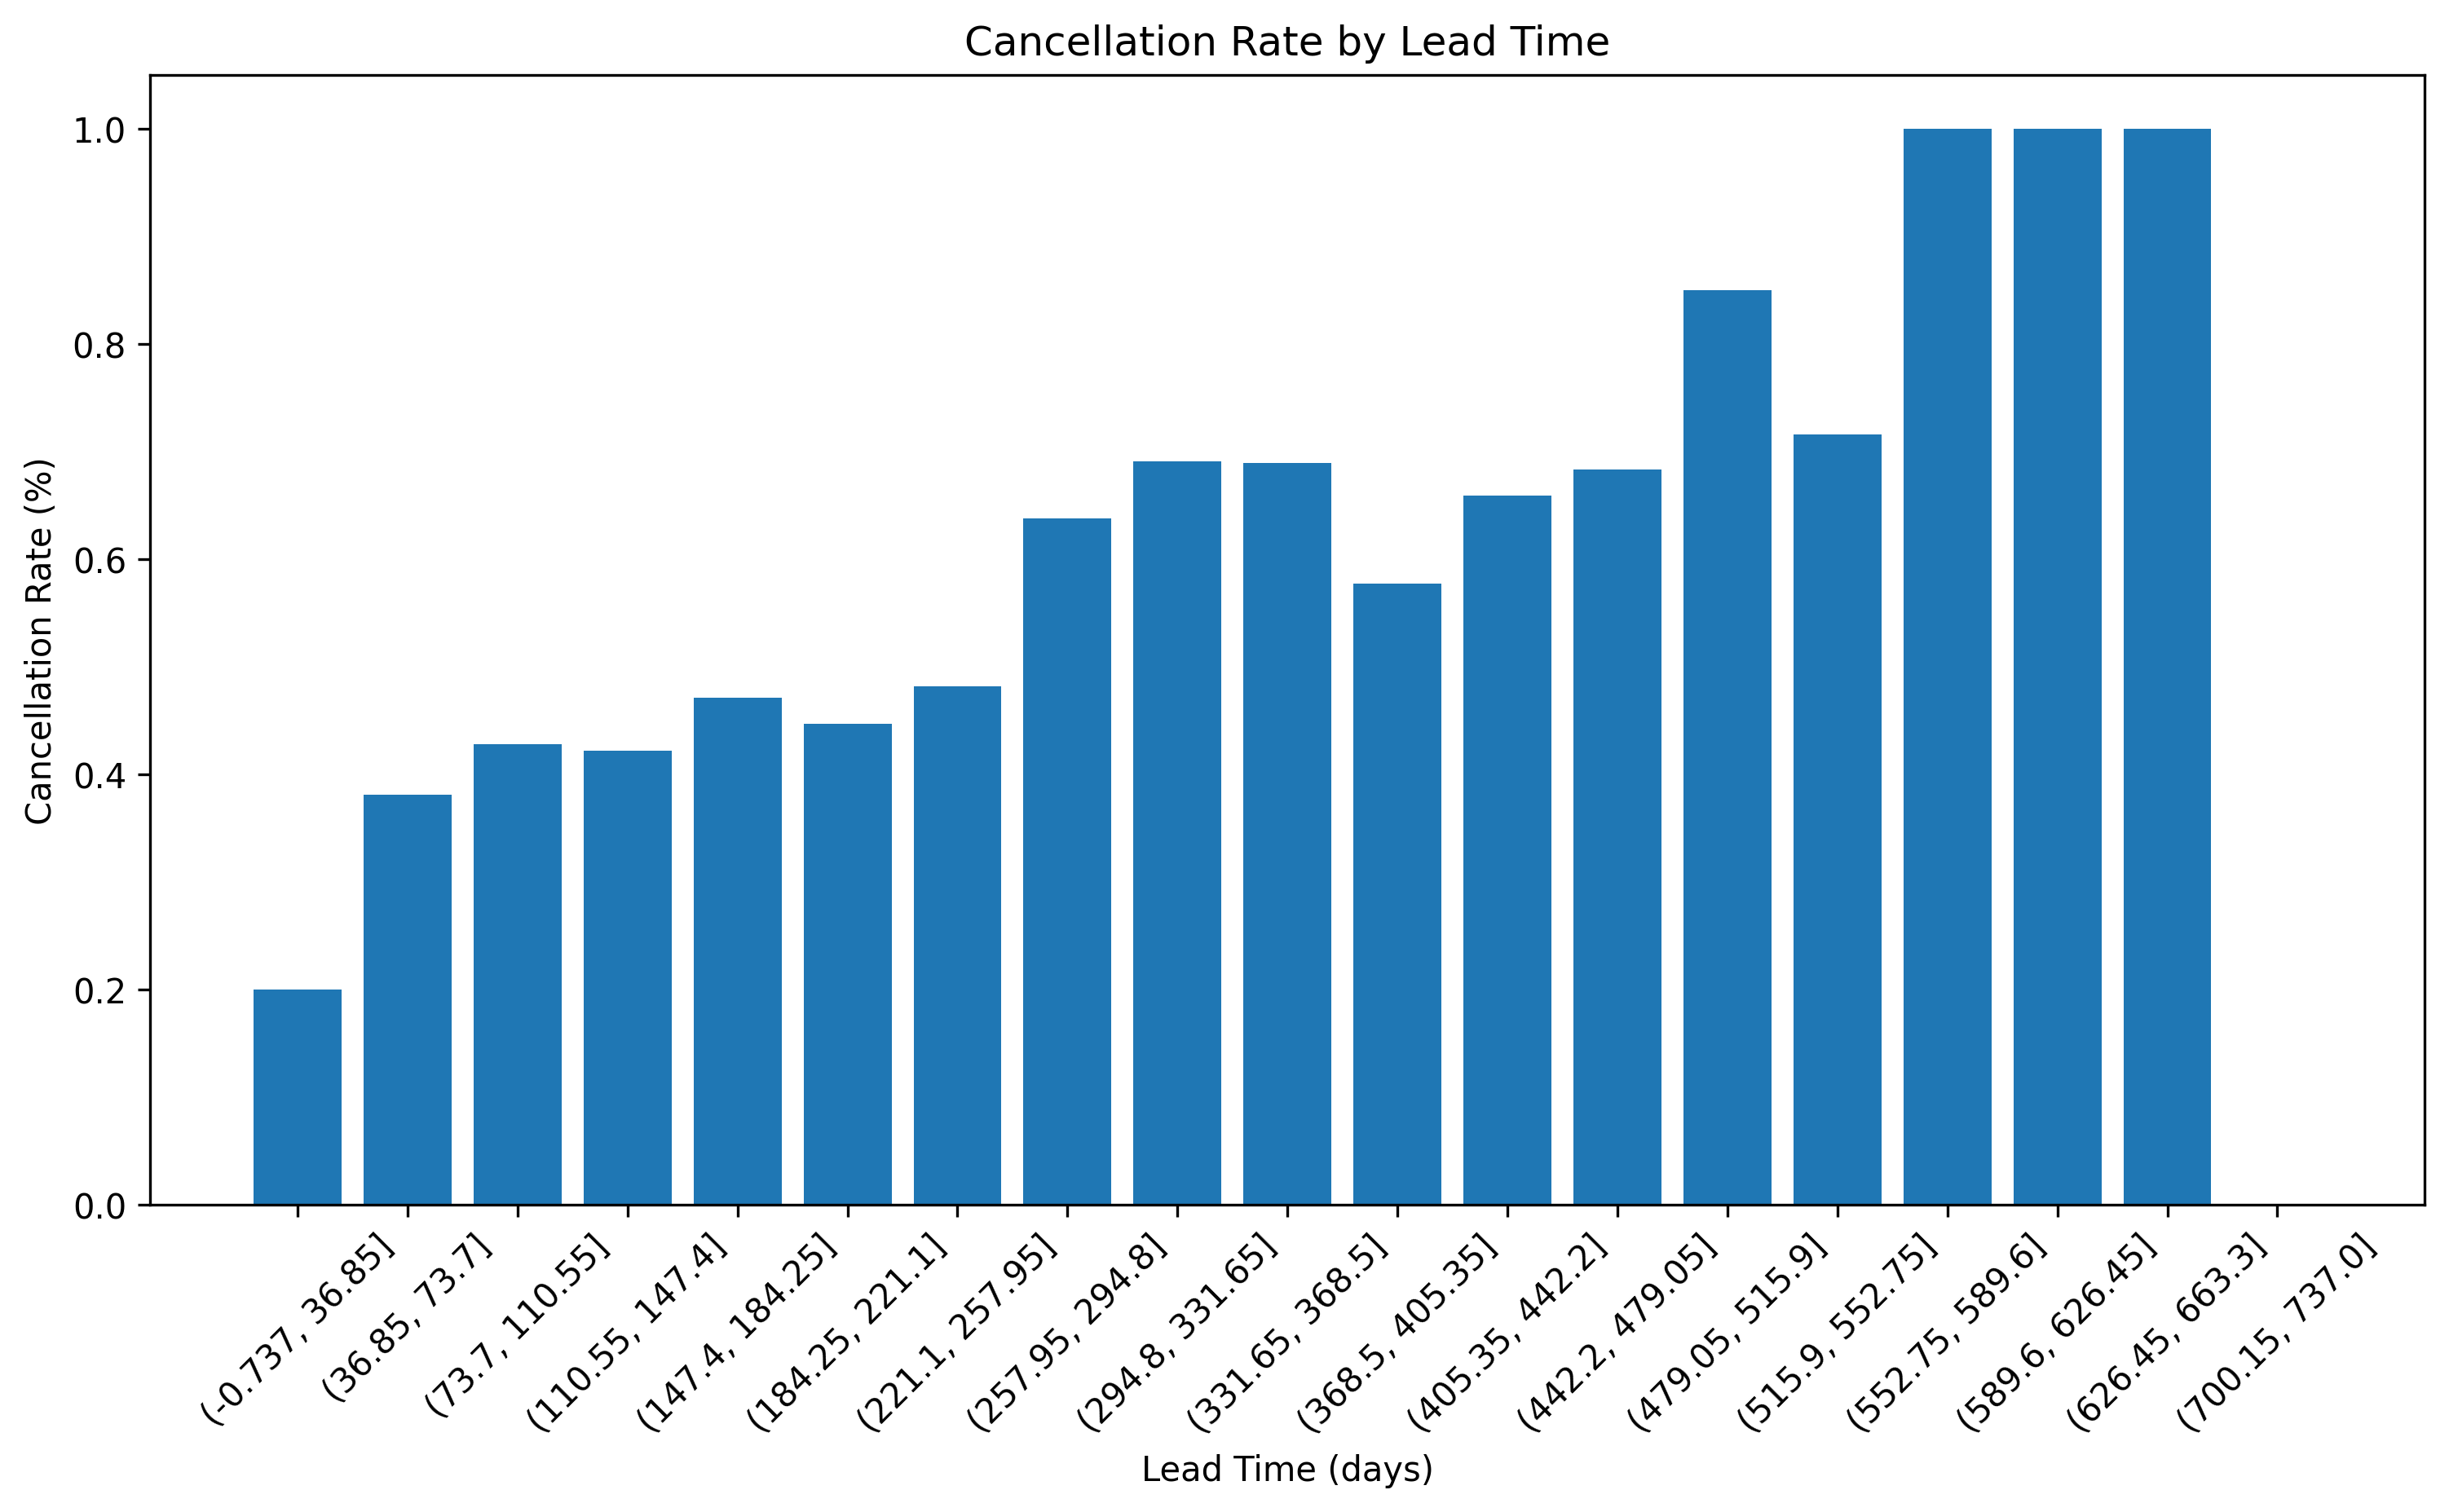

In [81]:
plt.figure(figsize=(12, 6))
df['lead_time_bins'] = pd.cut(df['lead_time'], bins=20)
df_lead_time_cancelled = df.groupby('lead_time_bins', observed=True).agg({'is_canceled': 'mean'})
plt.bar(df_lead_time_cancelled.index.astype(str), df_lead_time_cancelled['is_canceled'])
plt.title('Cancellation Rate by Lead Time')
plt.xlabel('Lead Time (days)')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.show()

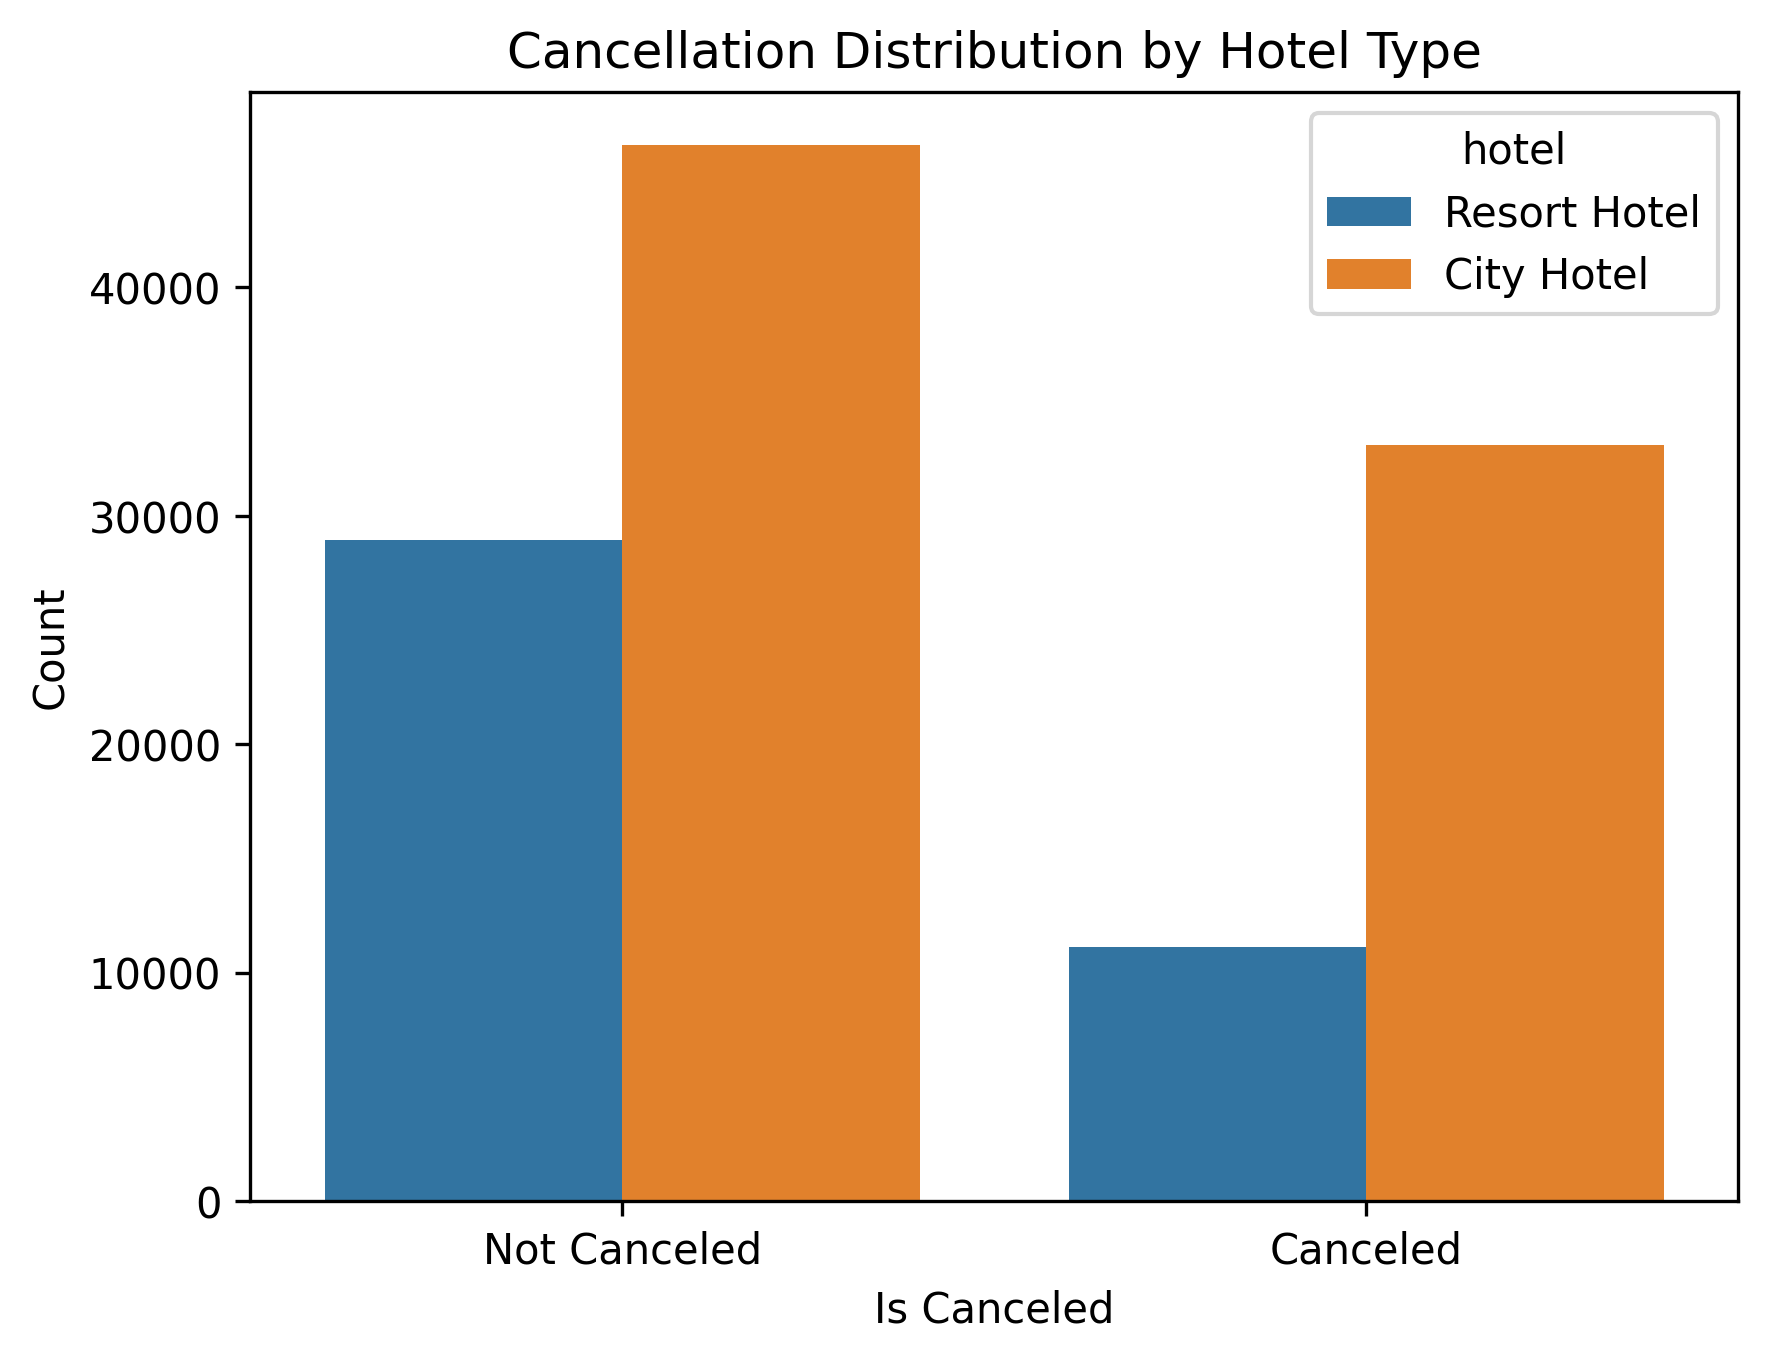

In [82]:
sns.countplot(data=df, x='is_canceled', hue='hotel')
plt.title('Cancellation Distribution by Hotel Type')
plt.xlabel('Is Canceled')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Canceled', 'Canceled'])
plt.show()


Key takeaways:

- A big percentage of bookings are cancelled
- City hotel seems to have a higher rate of cancellations. Could make sense if people travel to cities more for business and their plans change more often.

## Conclusions

Datascience is cool!

---
Luka Skeledžija, [Github source 🔗](https://github.com/lukaske/datascience-tools/blob/main/hotels-analysis.ipynb), 2025